In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
# from read_fk_table import get_fk_table
from read_faserv_pdf import read_pdf
# from read_LHEF import read_LHEF_data
from data_errors import compute_errors
from MC_data_reps import generate_MC_replicas
from postfit_criteria import Postfit
from form_loss_fct import complete_loss_fct, raw_loss_fct
from postfit_measures import Measures
from logspace_grid import generate_grid
# from rebin_fk_data import rebin_fk

In [2]:
# Define global variables
num_obs = 1 #between 1 and 4
REPLICAS  = 20

#HYPERPARAMETERS
preproc = 1

fit_level = 2

max_counter = 50
max_Nepochs = 3500

In [3]:
# from read_fk_table import get_fk_table

import pandas as pd
# import torch
import torch.nn.functional


def get_fk_table(filename):
    """This function reads the fk table for the neutrino flux and pads them for computational efficiency later on

    Returns:
        tuple: x_alphas(grid points) and the fk table in tensor to fit torch
    """

    file_path = f"data_muon_sim_faser/{filename}.dat"
    df = pd.read_csv(file_path, sep="\s+", header=None)
    fk_table = df.to_numpy()

    x_alpha = fk_table[0, :]
    x_alpha = x_alpha.reshape(len(x_alpha), 1)

    # strip first row to get fk table
    fk_table = fk_table[1:, :]

    x_alpha = torch.tensor(x_alpha, dtype=torch.float32).view(-1, 1)
    fk_table = torch.tensor(fk_table, dtype=torch.float32)

    return x_alpha, fk_table

filename = "FK_Enu_7TeV_nu_W"
x_alphas, fk_tables_mu = get_fk_table(filename = filename)
filename = "FK_Enu_7TeV_nub_W"
x_alphas, fk_tables_mub = get_fk_table(filename = filename)



<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_80194/957887329.py:16: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(file_path, sep="\s+", header=None)


LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/FASERv_EPOS+POWHEG_7TeV/FASERv_EPOS+POWHEG_7TeV_0000.dat
FASERv_EPOS+POWHEG_7TeV PDF set, member #0, version 1; LHAPDF ID = 70001000
LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/FASERv_EPOS+POWHEG_7TeV/FASERv_EPOS+POWHEG_7TeV_0000.dat
FASERv_EPOS+POWHEG_7TeV PDF set, member #0, version 1; LHAPDF ID = 70001000


/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_80194/1281056475.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  faser_pdf = torch.tensor(faser_pdf, dtype=torch.float32).view(-1,1)
/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_80194/1281056475.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  faser_pdf = torch.tensor(faser_pdf, dtype=torch.float32).view(-1,1)


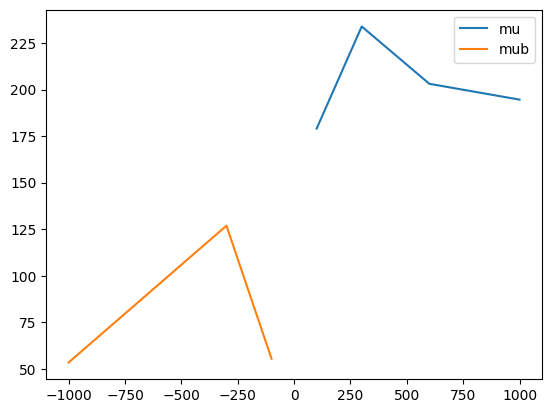

In [4]:
xvals_per_obs_mu = [100,300,600,1000]
pdf = "FASERv_EPOS+POWHEG_7TeV"
# pdf = "faserv"
faser_pdf,x_faser = read_pdf(pdf,x_alphas.flatten(),14)
faser_pdf = torch.tensor(faser_pdf, dtype=torch.float32).view(-1,1)
conv = torch.matmul(fk_tables_mu,faser_pdf) 
binwidths = [200,300,400,900]
binwidths = torch.tensor(binwidths, dtype=torch.float32).view(-1,1)
rel_dat = conv
plt.plot(xvals_per_obs_mu,conv*binwidths ,label='mu')

xvals_per_obs_mub = [-100,-300,-1000]
faser_pdf,x_faser = read_pdf(pdf,x_alphas.flatten(),-14)
faser_pdf = torch.tensor(faser_pdf, dtype=torch.float32).view(-1,1)
conv = torch.matmul(fk_tables_mub,faser_pdf) 
binwidths = [200,700,900]
binwidths = torch.tensor(binwidths, dtype=torch.float32).view(-1,1)
rel_dat = conv
plt.plot(xvals_per_obs_mub,conv *binwidths,label='mub')
# plt.plot(xvals_per_obs,data ,'o',label='data')
plt.legend()

In [5]:
# data, data_min, data_max, xvals_per_obs, binwidths, xlabels, events_per_obs = rebin_fk()
binwidths_mu = [200,300,400,900]
binwidths_mu = torch.tensor(binwidths_mu, dtype=torch.float32).view(-1,1)
faser_bins_mu = [300, 600, 1000,1900]
faser_pdf,x_faser = read_pdf(pdf,x_alphas.flatten(),14)
faser_pdf = torch.tensor(faser_pdf, dtype=torch.float32).view(-1,1)
data_mu  = torch.matmul(fk_tables_mu,faser_pdf) * binwidths_mu * 65.6/150
data_mu = data_mu.detach().numpy().flatten()
data_max_mu = data_mu + data_mu/20 
data_min_mu = data_mu - data_mu/20

binwidths_mub = [200,700,900]
faser_pdf,x_faser = read_pdf(pdf,x_alphas.flatten(),-14)
faser_pdf = torch.tensor(faser_pdf, dtype=torch.float32).view(-1,1)
binwidths_mub = torch.tensor(binwidths_mub, dtype=torch.float32).view(-1,1)
data_mub  = torch.matmul(fk_tables_mub,faser_pdf) * binwidths_mub* 65.6/150
data_mub = data_mub.detach().numpy().flatten()
data_max_mub = data_mub + data_mub/20 
data_min_mub = data_mub - data_mub/20
faser_bins_mub = [300, 1000,1900]

xvals_per_obs_mu = [100,300,600,1000]

xvals_per_obs = [100,300,600,1000,-300,-100]
xvals_per_obs_mub = [-100,-300,-1000]
xlabels = ['Enu']

LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/FASERv_EPOS+POWHEG_7TeV/FASERv_EPOS+POWHEG_7TeV_0000.dat
FASERv_EPOS+POWHEG_7TeV PDF set, member #0, version 1; LHAPDF ID = 70001000
LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/FASERv_EPOS+POWHEG_7TeV/FASERv_EPOS+POWHEG_7TeV_0000.dat
FASERv_EPOS+POWHEG_7TeV PDF set, member #0, version 1; LHAPDF ID = 70001000


/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_80194/180199630.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  faser_pdf = torch.tensor(faser_pdf, dtype=torch.float32).view(-1,1)
/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_80194/180199630.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  faser_pdf = torch.tensor(faser_pdf, dtype=torch.float32).view(-1,1)


LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/FASERv_EPOS+POWHEG_7TeV/FASERv_EPOS+POWHEG_7TeV_0000.dat
FASERv_EPOS+POWHEG_7TeV PDF set, member #0, version 1; LHAPDF ID = 70001000
LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/FASERv_EPOS+POWHEG_7TeV/FASERv_EPOS+POWHEG_7TeV_0000.dat
FASERv_EPOS+POWHEG_7TeV PDF set, member #0, version 1; LHAPDF ID = 70001000


/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_80194/1336265202.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  faser_pdf = torch.tensor(faser_pdf, dtype=torch.float32).view(-1,1)
/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_80194/1336265202.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  faser_pdf = torch.tensor(faser_pdf, dtype=torch.float32).view(-1,1)


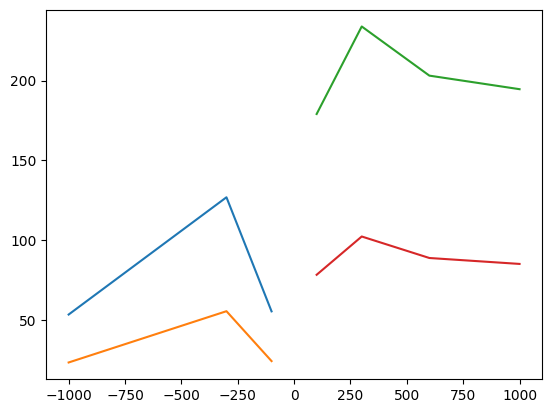

In [6]:
faser_pdf,x_faser = read_pdf(pdf,x_alphas.flatten(),-14)
faser_pdf = torch.tensor(faser_pdf, dtype=torch.float32).view(-1,1)
conv = torch.matmul(fk_tables_mub,faser_pdf) 
plt.plot(xvals_per_obs_mub,conv *binwidths_mub,label='mub')
plt.plot(xvals_per_obs_mub,data_mub)

faser_pdf,x_faser = read_pdf(pdf,x_alphas.flatten(),14)
faser_pdf = torch.tensor(faser_pdf, dtype=torch.float32).view(-1,1)
conv = torch.matmul(fk_tables_mu,faser_pdf) 
plt.plot(xvals_per_obs_mu,conv *binwidths_mu,label='mub')
plt.plot(xvals_per_obs_mu,data_mu)

In [7]:
def combine_mu_mub(mu,mub):
    mu[-1] = mu[-1] + mub[-1]
    mub = mub[:-1]
    mub = mub[::-1]         
    combined = np.hstack((mu, mub))
    return combined


sig_sys_mu,sig_tot_mu, cov_matrix_mu = compute_errors(data_mu,data_min_mu,data_max_mu)  
sig_sys_mub,sig_tot_mub, cov_matrix_mub = compute_errors(data_mub,data_min_mub,data_max_mub)
#Combine data and errors
sig_stat_mu = np.sqrt(data_mu)
sig_stat_mub = np.sqrt(data_mub)
sig_stat = combine_mu_mub(sig_stat_mu,sig_stat_mub)

sig_sys = combine_mu_mub(sig_sys_mu,sig_sys_mub)

data = combine_mu_mub(data_mu,data_mub)

sig_tot = sig_stat**2 + sig_sys**2
cov_matrix = np.diag(sig_tot)
cov_matrix = np.linalg.inv(cov_matrix)
cov_matrix = torch.tensor(cov_matrix, dtype=torch.float32, requires_grad=False)
#1. sig stat
#2. sig sys
#3. events
#4. xvals_per_obs


In [8]:
# jelle_fk = 1
# file_path_n = "data/jelle_fk.dat"
# df = pd.read_csv(file_path_n, sep="\s+", header=None)
# fk_table_jelle = df.to_numpy()

# x_alpha = fk_table_jelle[0, :]
# x_alpha = x_alpha.reshape(len(x_alpha), 1)

# # strip first row to get fk table
# fk_table_jelle = fk_table_jelle[1:, :]

# x_alpha = torch.tensor(x_alpha, dtype=torch.float32).view(-1, 1)
# fk_table_jelle = torch.tensor(fk_table_jelle, dtype=torch.float32)




# # pdf = "FASERv_EPOS+POWHEG_7TeV"
# # pdf = "faserv"
# faser_pdf,x_faser = read_pdf(pdf,x_alphas.flatten(),14)
# faser_pdf = torch.tensor(faser_pdf, dtype=torch.float32).view(-1,1)
# conv = torch.matmul(fk_tables_mu,faser_pdf) * binwidths 
# plt.plot(xvals_per_obs_mu,conv,label='conv')
# # print(conv.detach().numpy().flatten()/data[:-2])
# faser_pdf,x_faser = read_pdf(pdf,x_alphas.flatten(),-14)
# faser_pdf = torch.tensor(faser_pdf, dtype=torch.float32).view(-1,1)
# conv = torch.matmul(fk_tables_mub,faser_pdf) * binwidths 
# plt.plot(xvals_per_obs_mub,conv,label='conv2')

# faser_pdf,x_faser = read_pdf(pdf,x_alphas.flatten(),14)
# faser_pdf = torch.tensor(faser_pdf, dtype=torch.float32).view(-1,1)
# conv = torch.matmul(fk_table_jelle,faser_pdf) * binwidths 
# plt.plot(xvals_per_obs_mu,conv,label='convjelle')

# plt.plot(xvals_per_obs,data,'o',label='data')
# plt.legend()
# print(conv.detach().numpy().flatten())
# print(data[:-2])


In [9]:
# data,data_min,data_max,xvals_per_obs,binwidths,xlabels,events_per_obs,fk_tables,x_alphas = rebin_fk(rebin=1)

In [10]:
#Get errors
# sig_sys,sig_tot, cov_matrix = compute_errors(data,data_min,data_max)  
# xvals_per_obs = [100,300,600,-100,-300,1000] 
# xvals_per_obs = [100,300,600,100,-300,-100]  
# cov_matrix = np.array([
#     [9.2,-0.32,  0.08, -0.03,  0.00,  0.00],
#     [-0.32, 10.2, -0.43,  0.10, -0.01, -0.00],
#     [ 0.08, -0.43, 9.6, -0.31,  0.04, -0.02],
#     [-0.03,  0.10, -0.31, 22.3,-0.14,  0.01],
#     [ 0.00, -0.01,  0.04, -0.14, 12.1,-0.24],
#     [ 0.00, -0.00, -0.02,  0.01, -0.24,7.5]
# ])
# cov_matrix = np.array([
#     [5186, -1623,  340,  -69,    2,    5],
#     [-1623, 6239, -1952,  281,  -19,   -4],
#     [  340, -1952, 4165, -734,   56,  -27],
#     [  -69,   281, -734, 1738, -130,   15],
#     [    2,   -19,   56, -130,  622, -147],
#     [    5,    -4,  -27,   15, -147,  847]
# ])
# sig_sys = np.array(sig_sys)
# # np.fill_diagonal(cov_matrix, sig_stat**2 + sig_sys**2)
# cov_matrix = np.linalg.inv(cov_matrix)
# cov_matrix = torch.tensor(cov_matrix, dtype=torch.float32, requires_grad=False)
#Generate MC replicas of data
level0,level1,level2 = generate_MC_replicas(REPLICAS,data,sig_sys,sig_stat)
# Get faserv pdf
pdf = "FASERv_EPOS+POWHEG_7TeV"
lowx = -8
n=250
x_vals = generate_grid(lowx,n)
faser_pdf,x_faser = read_pdf(pdf,x_vals,14)

LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/FASERv_EPOS+POWHEG_7TeV/FASERv_EPOS+POWHEG_7TeV_0000.dat
FASERv_EPOS+POWHEG_7TeV PDF set, member #0, version 1; LHAPDF ID = 70001000


In [11]:
if fit_level ==0:
    pred = level0
if fit_level ==1:
    pred = level1
if fit_level ==2:
    pred = level2

[ 78.29619  102.282326  88.811775 108.44622   55.481354  24.218927]
[tensor([ 73.0156, 101.5053,  88.8929, 131.6042,  44.7107,  26.4054]), tensor([ 82.3203,  95.9678,  72.1814, 117.7350,  70.3839,  34.7056]), tensor([ 86.2263,  91.6305, 106.1253, 115.9616,  58.7694,  25.3895]), tensor([ 84.5080, 117.1297,  96.0032, 116.7441,  53.6901,  21.0816]), tensor([ 67.9312, 120.1947,  95.1863, 130.8723,  54.6086,  18.5615]), tensor([ 63.7694,  86.3557,  81.6208, 116.6915,  64.1752,  24.1327]), tensor([82.0981, 88.5148, 79.2295, 93.9276, 64.5516, 23.9452]), tensor([ 84.5685, 105.3680,  93.7930, 121.7318,  52.4010,  17.5065]), tensor([ 81.7592,  86.4939,  82.5572, 133.3474,  60.7428,  10.1810]), tensor([ 92.2558, 100.6324,  93.2792,  96.8548,  49.5894,  23.0011]), tensor([ 92.3418, 101.6149,  92.0692, 128.8911,  45.0068,  21.6222]), tensor([ 75.7051, 109.3493,  95.8195, 122.5813,  60.6962,  24.3602]), tensor([ 80.7812, 105.8161,  92.2788, 112.5493,  62.7805,  16.7462]), tensor([83.9297, 98.4236, 9

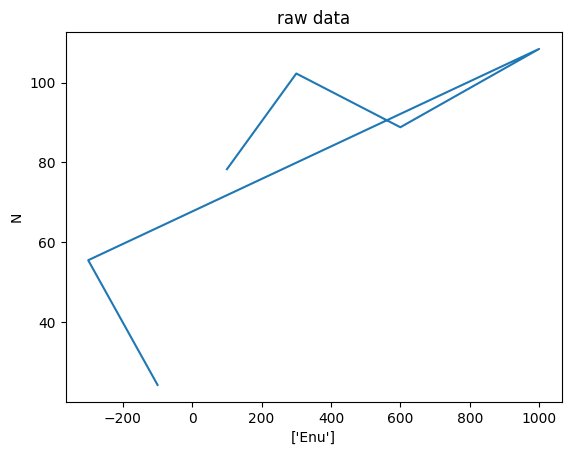

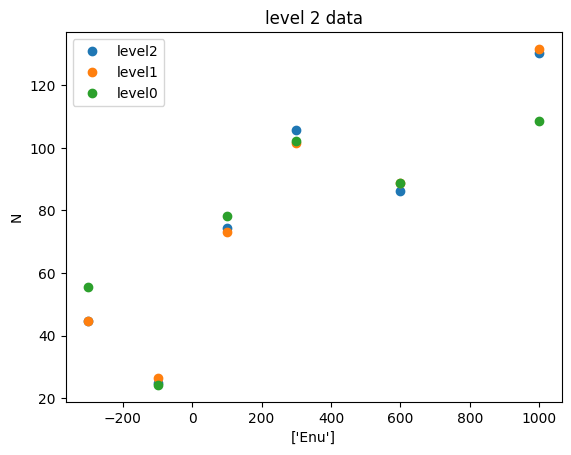

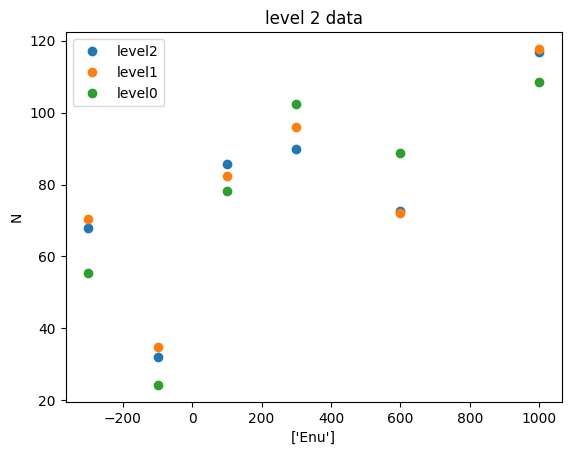

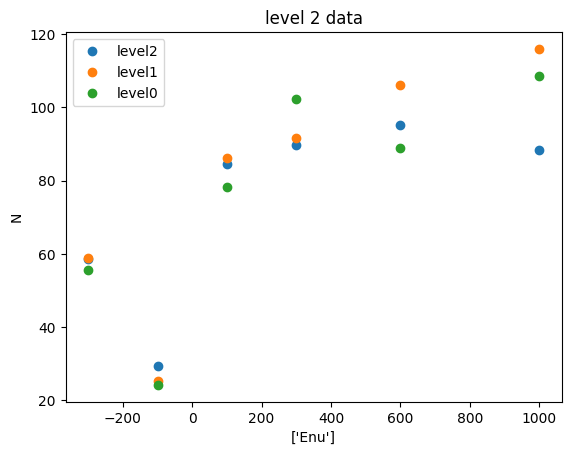

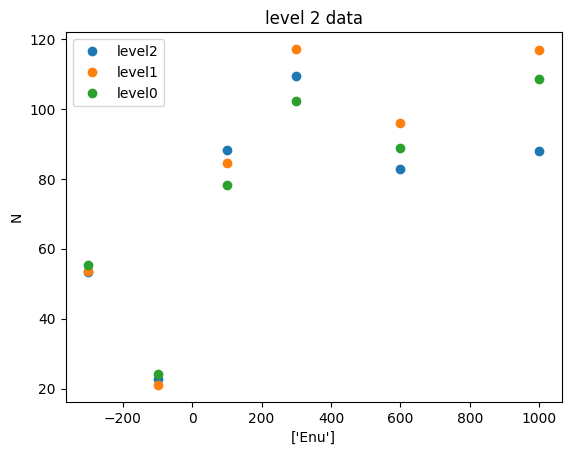

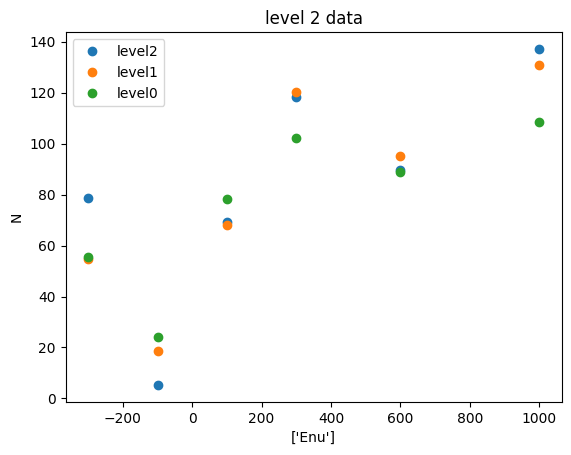

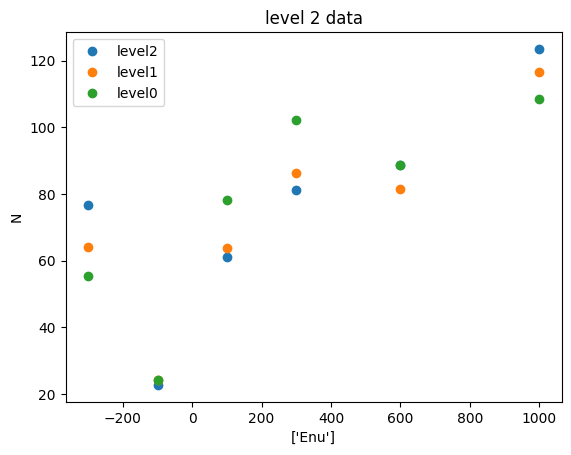

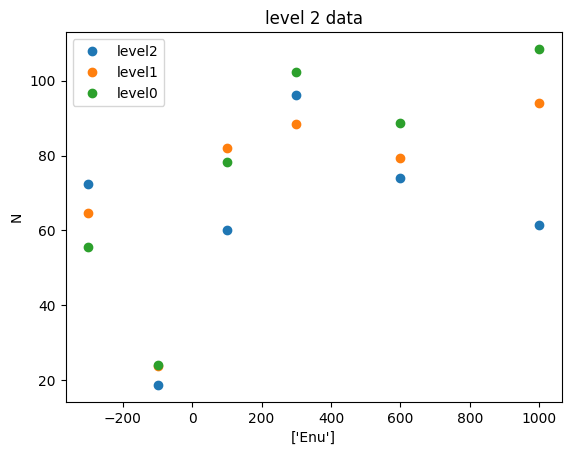

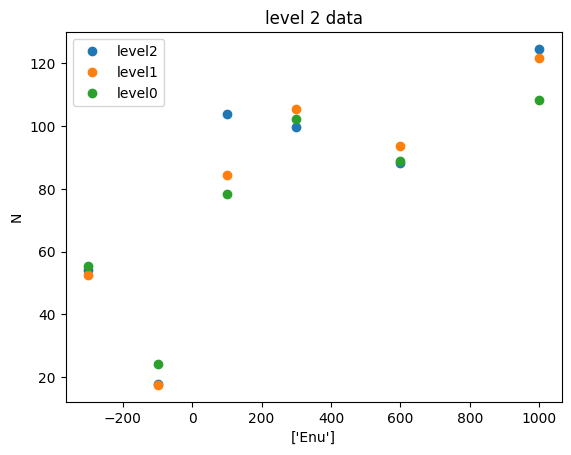

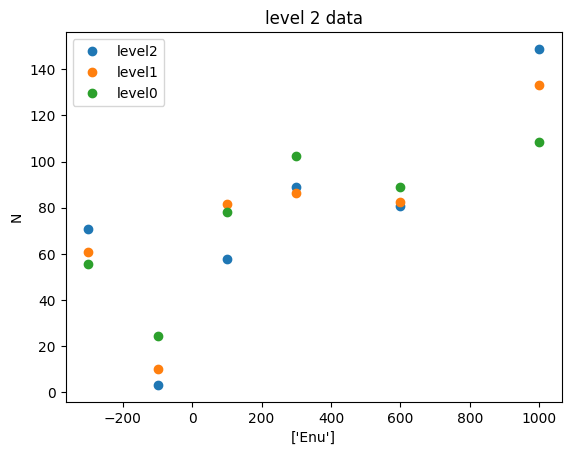

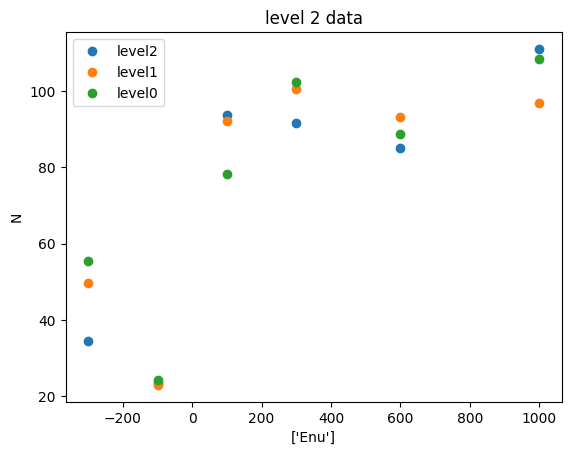

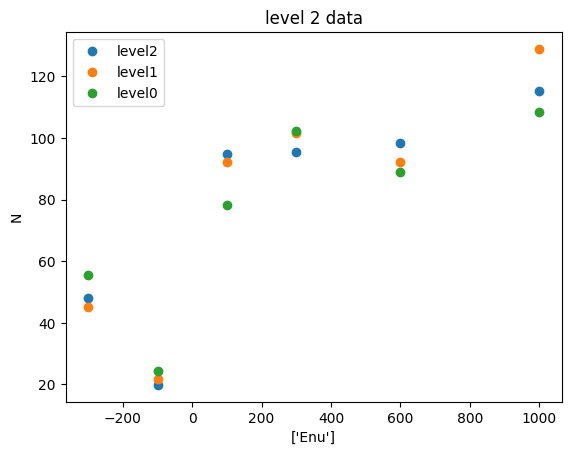

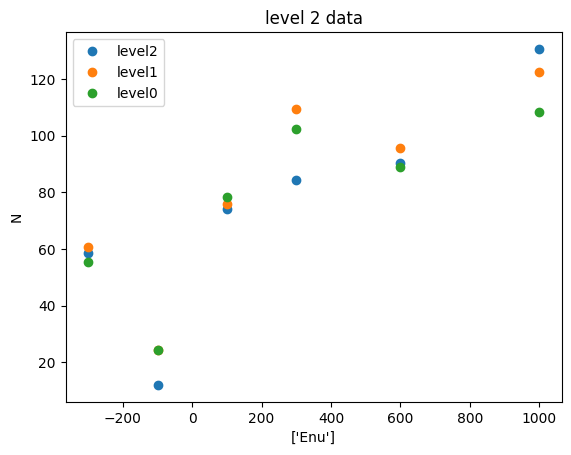

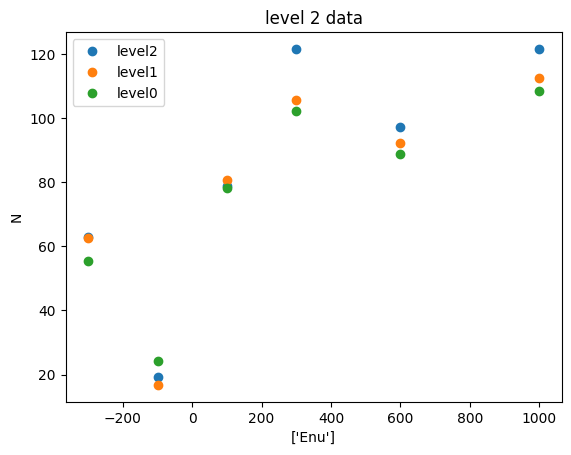

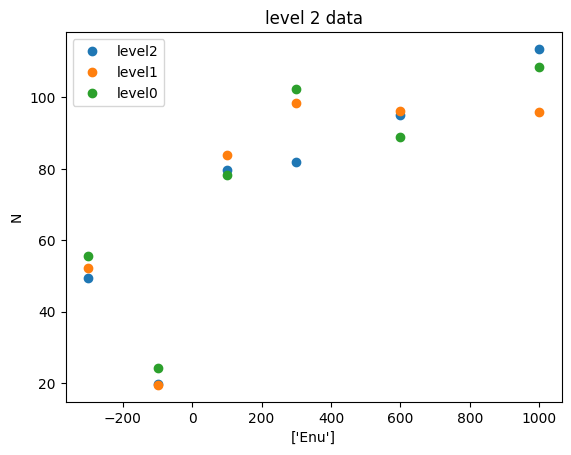

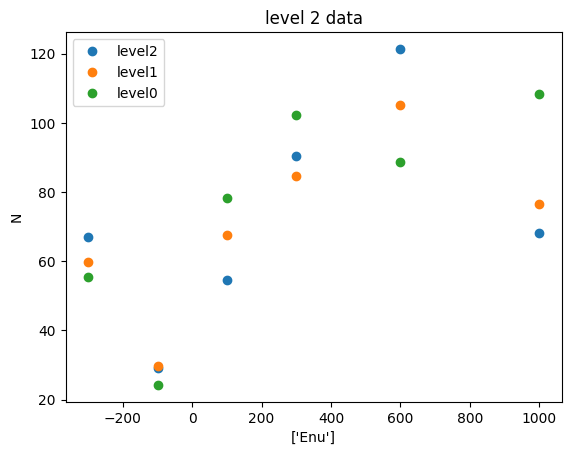

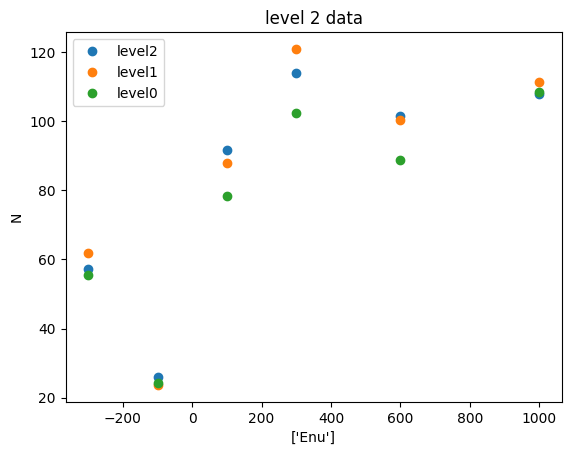

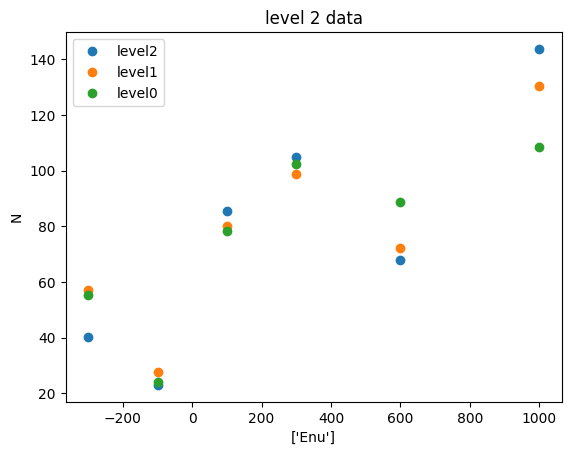

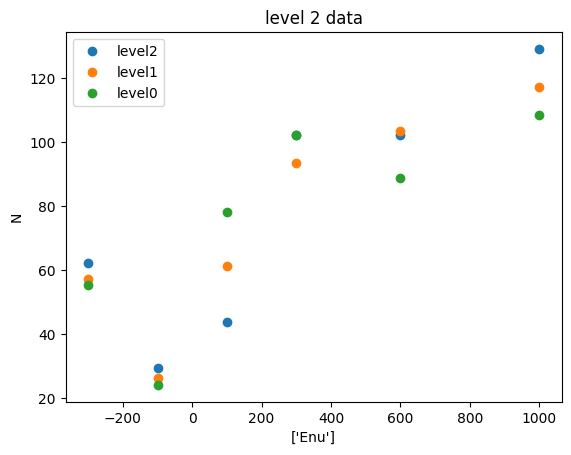

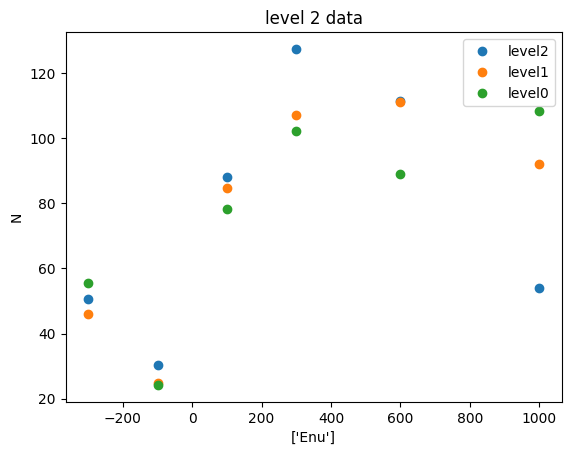

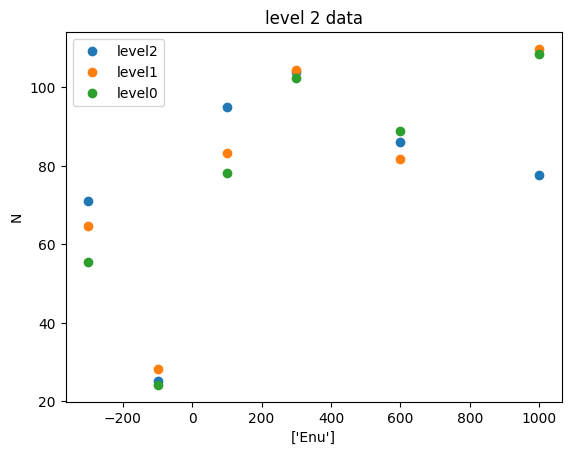

In [12]:
print(data)
print(level1)
print(level2)
plt.plot(xvals_per_obs,data)
plt.xlabel(xlabels)
plt.ylabel('N')
plt.title("raw data")
plt.show()

for i in range(REPLICAS):
    plt.plot(
        xvals_per_obs, level2[i], 'o',label="level2"
    )
    plt.plot(
        xvals_per_obs, level1[i], 'o',label="level1"
    )
    plt.plot(xvals_per_obs, data,'o',label="level0")
    plt.xlabel(xlabels)
    plt.legend()
    plt.ylabel("N")
    plt.title("level 2 data")
    plt.show()


In [13]:
import torch.nn as nn
import torch.nn.init as init

l1 = 2
l2 = 2
l3 = 2

class SimplePerceptron(torch.nn.Module):
    def __init__(self, l1,l2,l3):
        super(SimplePerceptron, self).__init__()
        self.linear = torch.nn.Linear(1,l1)
        self.hidden = torch.nn.Linear(l1,l2)
        self.hidden2 = torch.nn.Linear(l2,l3)
        self.hidden3 = torch.nn.Linear(l3,2)

        self.tanh = torch.nn.Softplus()
        self.relu = torch.nn.Softplus()

    # def _initialize_weights(self):
        
    #           # Set weights in range [-0.1, 0.1]
    #         init.zeros_(layer.bias)  # Initialize biases to 0

    def forward(self, y):
        y = self.linear(y)
        y = self.tanh(y)
        y = self.hidden(y)
        y = self.tanh(y)
        y = self.hidden2(y)
        y = self.tanh(y)
        y = self.hidden3(y)
        y = self.tanh(y)

        # y = self.hidden4(y)
        # y = self.tanh(y)

        # y = self.hidden5(y)
        # y = self.tanh(y)
        # y = torch.nn.functional.softplus(y)
    
        return y

In [14]:
import torch.nn as nn

if preproc == 1:
    class CustomPreprocessing(nn.Module):
        def __init__(self, alpha,beta,gamma):
            super(CustomPreprocessing, self).__init__()

            self.alpha = nn.Parameter(torch.tensor(alpha, dtype=torch.float32, requires_grad=True))
            self.beta = nn.Parameter(torch.tensor(beta, dtype=torch.float32, requires_grad=True))
            self.gamma = nn.Parameter(torch.tensor(gamma, dtype=torch.float32, requires_grad=True))

            # self.register_buffer("alpha", torch.tensor(alpha, dtype=torch.float32))
            # self.register_buffer("beta", torch.tensor(beta, dtype=torch.float32))
            # self.register_buffer("gamma", torch.tensor(gamma, dtype=torch.float32))

        def forward(self, x):
            # alpha = (1 - 0.2)/2 *torch.tanh(self.alpha) + (1 + 0.2)/2
            # beta = (1.9 - 0.1)/2 *torch.tanh(self.alpha) + (1.9 + 0.1)/2
            # beta = torch.nn.functional.softmax(self.beta)
            # alpha = 1 - torch.nn.functional.softplus(self.alpha)
            # return self.gamma * (1 - x) ** self.beta * x**(1-self.alpha) 
            x = torch.clamp(x, 1e-6, 1 - 1e-6)
            # return (1 - x)* x
            return  self.gamma*(1 - x) ** self.beta * x**(1-self.alpha) 
        
    class PreprocessedMLP(nn.Module):
        def __init__(self, alpha, beta, gamma,l1, l2, l3):
            super(PreprocessedMLP, self).__init__()
            self.preprocessing = CustomPreprocessing(alpha, beta,gamma)
            self.mlp = SimplePerceptron(l1, l2, l3)

        def forward(self, x):
            f_preproc = self.preprocessing(x)
            f_NN = self.mlp(x)
            f_nu = f_preproc * f_NN
            return f_nu
            # return f_NN - self.mlp(torch.tensor([1.], dtype=torch.float32).view(-1,1)) 
        
        def neuralnet(self, x):
            f_NN = self.mlp(x)
            return f_NN
        
        def preproc(self, x):
            f_preproc = self.preprocessing(x)
            return f_preproc
        


In [15]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss,self).__init__()

    def forward(self,pred,
    data,
    cov_matrix,small_x_point_mu, small_x_point_mub,model):
        loss = raw_loss_fct(pred,
    data,
    cov_matrix,small_x_point_mu,small_x_point_mub,model)
        return loss

In [16]:
#Define variables for fit
# x_alpha_more_bins = np.logspace(-5,0,250)
# x_alpha_more_bins = torch.tensor(x_alpha_more_bins, dtype=torch.float32).view(-1,1)
lowx = -8
n=250
# x_vals = generate_grid(lowx,n)
x_vals = np.logspace(-5,0,1000)
faser_pdf_mu = read_pdf(pdf,x_vals,14)
faser_pdf_mub = read_pdf(pdf,x_vals,-14)
x_vals = torch.tensor(x_vals, dtype=torch.float32).view(-1,1)
faser_pdf_mu,_ = read_pdf(pdf,x_vals.detach().numpy().flatten(),14)
faser_pdf_mub,_ = read_pdf(pdf,x_vals.detach().numpy().flatten(),-14)
neutrino_pdfs_mu,neutrino_pdfs_mub,N_event_pred, arc_lenghts, chi_squares, int_penaltys,pos_penaltys, preproc_pdfs, nn_pdfs  = [],[],[],[],[],[],[],[],[]


LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/FASERv_EPOS+POWHEG_7TeV/FASERv_EPOS+POWHEG_7TeV_0000.dat
FASERv_EPOS+POWHEG_7TeV PDF set, member #0, version 1; LHAPDF ID = 70001000
LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/FASERv_EPOS+POWHEG_7TeV/FASERv_EPOS+POWHEG_7TeV_0000.dat
FASERv_EPOS+POWHEG_7TeV PDF set, member #0, version 1; LHAPDF ID = 70001000
LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/FASERv_EPOS+POWHEG_7TeV/FASERv_EPOS+POWHEG_7TeV_0000.dat
FASERv_EPOS+POWHEG_7TeV PDF set, member #0, version 1; LHAPDF ID = 70001000
LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/FASERv_EPOS+POWHEG_7TeV/FASERv_EPOS+POWHEG_7TeV_0000.dat
FASERv_EPOS+POWHEG_7TeV PDF set, member #0, version 1; LHAPDF ID = 70001000


In [17]:
lr = 0.01
# self.gamma*(1 - x) ** self.beta * x**(1-self.alpha) 

def perform_fit(pred,REPLICAS):
    
    for i in range(REPLICAS):
        if preproc == 1:
            alpha,beta,gamma = np.random.uniform(-5,1), np.random.uniform(-20,20), np.random.uniform(0,100), 
            model = PreprocessedMLP(alpha, beta, gamma,l1, l2, l3)

            print(alpha,beta,gamma)



        # print("Initial weights:")
        # for name, param in model.named_parameters():
        #     if 'weight' in name:  # Only print weights, skip biases
        #         print(f"{name}:\n{param.data}\n")

                
        # model.load_state_dict(model_params)    

        criterion = CustomLoss()
        # criterion = torch.nn.MSELoss()
        # optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-2)  
        for name, param in model.named_parameters():
            if torch.isnan(param).any():
                print(f"NaN detected in parameter {name} before training")

        losses = []
        pred[i] = pred[i].squeeze()
        # max_pred = max(pred[i])
        # min_pred = min(pred[i])
        # pred[i] = (pred[i] - min(pred[i]))/ (max(pred[i])-min(pred[i]))
        model.train()
        best_loss = 1e13 # initial loss
        counter = 0
        num_epochs = 8000
        # num_epochs = 0
        # for ep in range(num_epochs):
        
        while counter < max_counter:  
            
        #     if num_epochs>max_Nepochs:
        #         break
            
            # num_epochs+=1
            optimizer.zero_grad()
            # y_pred =  model(x_alphas) 
            if torch.isnan(x_alphas).any():
                print("NaN detected in input x_alphas!")
            y_pred =  model(x_alphas) 
            if torch.isnan(y_pred).any():
                print("NaN detected in model predictions!")
            
            # y_pred_mu = torch.matmul(fk_tables_mu,y_pred[:,0]- model(torch.tensor([.95], dtype=torch.float32).view(-1,1))[:,0]  )  * binwidths_mu.flatten() 
            # y_pred_mub = torch.matmul(fk_tables_mub,y_pred[:,1]- model(torch.tensor([.95], dtype=torch.float32).view(-1,1))[:,1]  )  * binwidths_mub.flatten()
            y_pred_mu = torch.matmul(fk_tables_mu,y_pred[:,0])* binwidths_mu.flatten() 
            y_pred_mub = torch.matmul(fk_tables_mub,y_pred[:,1]) * binwidths_mub.flatten()
            
            # print(torch.matmul(fk_tables_mu,y_pred[:,0]).shape)
            # print(torch.matmul(fk_tables_mub,y_pred[:,0]).shape)
            # print(binwidths_mu.shape)
            # print(binwidths_mub.shape)

            # print(y_pred_mu.shape)
            # print(y_pred_mub.shape)

            y_pred_mu = y_pred_mu.squeeze()
            y_pred_mub = y_pred_mub.squeeze()

            y_pred_mu[-1] = y_pred_mu[-1] + y_pred_mub[-1]
            
            y_pred_mub = y_pred_mub[:-1]

            y_pred_mub = torch.flip(y_pred_mub, dims=[0])
            
            y_preds = torch.hstack((y_pred_mu, y_pred_mub))

            small_x_point_mu = model(torch.tensor([6*10**-4], dtype=torch.float32).view(-1,1))[:,0] 
            small_x_point_mub = model(torch.tensor([6*10**-4], dtype=torch.float32).view(-1,1))[:,1]
            large_x_point_mu = model(torch.tensor([1.], dtype=torch.float32).view(-1,1))[:,0]
            loss = criterion(y_preds, pred[i],cov_matrix,small_x_point_mu,small_x_point_mub,large_x_point_mu)
            # loss = criterion(y_preds, pred[i])

           

            loss.backward()
            print(loss)   

            for name, param in model.named_parameters():
                if param.grad is not None and torch.isnan(param.grad).any():
                    print(f"NaN detected in gradients of {name}!")
                    print(y_preds)
    
            losses.append(loss.detach().numpy())
            optimizer.step()
            
            # if ep % 100 == 0:
            #     print(loss.detach().numpy())   
            if abs(loss) <1.:
                break
            if loss < best_loss:
                best_loss = loss
                counter = 0
            else:
                counter +=1   

        if loss < 5:    

            print(f"reduced chi^2 level 2 = {loss}")
            # print(f"reduced chi^2 level 1 = {red_chi_square_level1}")
            print(f"Constrained alpha: {(model.preprocessing.alpha.item())}")
            print(f"Constrained beta: {(model.preprocessing.beta.item())}")
            print(f"Constrained gamma: {model.preprocessing.gamma.item()}") 

            # save outcome of fit and its measures for postfit selection criteria
            chi_squares.append(loss.detach().numpy())
            # preproc_pdf = ((1 - x_alpha_more_bins) ** (beta) * x_alpha_more_bins ** (1-alpha)).detach().numpy().flatten()
            f_nu_mub = model(x_vals)[:,1].detach().numpy().flatten()  
            f_nu_mu = model(x_vals)[:,0].detach().numpy().flatten() 
            
            # print(preproc_pdf.shape)

            preproc_pdf = model.preproc(x_vals).detach().numpy().flatten()
            preproc_pdfs.append(model.preproc(x_vals).detach().numpy().flatten())
            nn_pdfs.append(model.neuralnet(x_vals)[:,0].detach().numpy().flatten())

            N_event_pred.append(y_preds.detach().numpy())
            plt.plot(xvals_per_obs,y_preds.detach().numpy().flatten(),label = 'nn')
            plt.plot(xvals_per_obs,pred[i],label = 'level2')
            plt.legend()
            plt.show()
            plt.plot(x_vals,f_nu_mu,label='fit mu')
            plt.plot(x_vals,f_nu_mub ,label='fit mub')
            plt.plot(x_vals,faser_pdf_mu,label='faser')
            # plt.xlim(200/7000,1450/7000)
            # plt.plot(x_vals,faser_pdf_mu,label='fasermu')
            # plt.plot(x_vals,faser_pdf_mub,label='fasermub')
            # plt.ylim(10**-3,10**6)
            plt.xscale('log')
            plt.yscale('log')
            plt.legend()
            plt.show()

            # cont_pred = model(x_alpha_more_bins).detach().numpy().flatten()
            neutrino_pdfs_mu.append(f_nu_mu)
            neutrino_pdfs_mub.append(f_nu_mub)
            plt.yscale('log')
            print(f'counter = {counter}')
            plt.plot(range(1, len(losses) + 1), losses)
            plt.xlabel('#epochs')
            plt.ylabel('loss')
            plt.title('level 0 closure test, no preprocessing')
            plt.show()
            # plt.plot(x_alpha_more_bins,preproc_pdf)
            # plt.xscale('log')
            # plt.yscale('log')
            # plt.show()
            print(small_x_point_mu)
            print(small_x_point_mub)
    # return arc_lenghts, chi_squares,pos_penaltys,int_penaltys,N_event_pred, neutrino_pdfs,model

    return chi_squares,N_event_pred, neutrino_pdfs_mu,neutrino_pdfs_mub,model

-0.2061927582279779 17.159659890089884 91.92628118025142


tensor(343.8877, grad_fn=<AddBackward0>)
tensor(343.8536, grad_fn=<AddBackward0>)
tensor(343.8180, grad_fn=<AddBackward0>)
tensor(343.7809, grad_fn=<AddBackward0>)
tensor(343.7422, grad_fn=<AddBackward0>)
tensor(343.7018, grad_fn=<AddBackward0>)
tensor(343.6595, grad_fn=<AddBackward0>)
tensor(343.6154, grad_fn=<AddBackward0>)
tensor(343.5692, grad_fn=<AddBackward0>)
tensor(343.5208, grad_fn=<AddBackward0>)
tensor(343.4702, grad_fn=<AddBackward0>)
tensor(343.4170, grad_fn=<AddBackward0>)
tensor(343.3611, grad_fn=<AddBackward0>)
tensor(343.3025, grad_fn=<AddBackward0>)
tensor(343.2408, grad_fn=<AddBackward0>)
tensor(343.1758, grad_fn=<AddBackward0>)
tensor(343.1074, grad_fn=<AddBackward0>)
tensor(343.0352, grad_fn=<AddBackward0>)
tensor(342.9589, grad_fn=<AddBackward0>)
tensor(342.8783, grad_fn=<AddBackward0>)
tensor(342.7931, grad_fn=<AddBackward0>)
tensor(342.7028, grad_fn=<AddBackward0>)
tensor(342.6071, grad_fn=<AddBackward0>)
tensor(342.5055, grad_fn=<AddBackward0>)
tensor(342.3975,

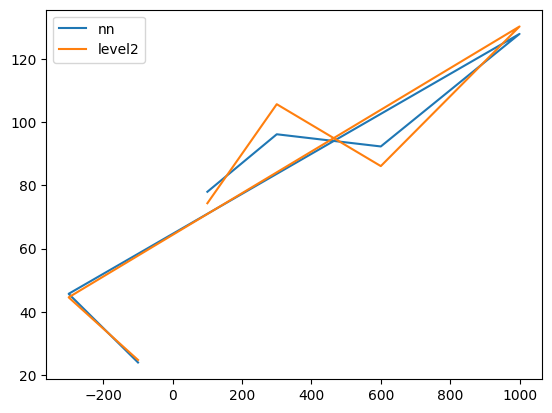

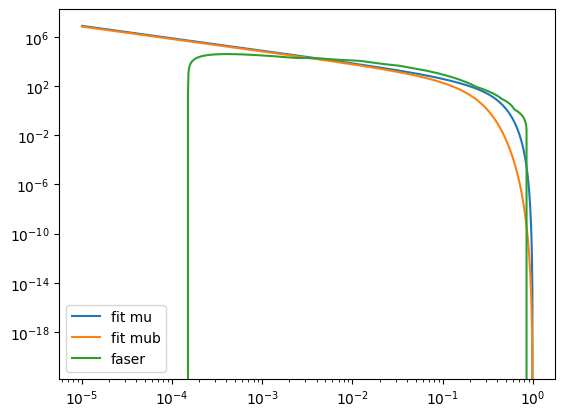

counter = 50


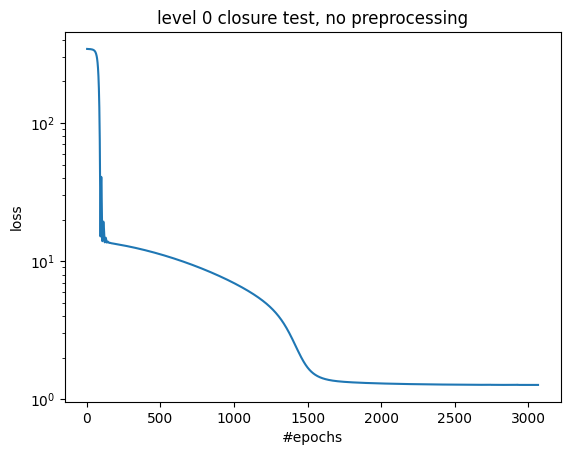

tensor([127645.0547], grad_fn=<SelectBackward0>)
tensor([111826.8828], grad_fn=<SelectBackward0>)
-0.5758751997686291 17.763057052921603 34.56714291528347
tensor(363.1905, grad_fn=<AddBackward0>)
tensor(363.1849, grad_fn=<AddBackward0>)
tensor(363.1792, grad_fn=<AddBackward0>)
tensor(363.1732, grad_fn=<AddBackward0>)
tensor(363.1668, grad_fn=<AddBackward0>)
tensor(363.1602, grad_fn=<AddBackward0>)
tensor(363.1533, grad_fn=<AddBackward0>)
tensor(363.1460, grad_fn=<AddBackward0>)
tensor(363.1383, grad_fn=<AddBackward0>)
tensor(363.1302, grad_fn=<AddBackward0>)
tensor(363.1218, grad_fn=<AddBackward0>)
tensor(363.1128, grad_fn=<AddBackward0>)
tensor(363.1033, grad_fn=<AddBackward0>)
tensor(363.0933, grad_fn=<AddBackward0>)
tensor(363.0827, grad_fn=<AddBackward0>)
tensor(363.0714, grad_fn=<AddBackward0>)
tensor(363.0594, grad_fn=<AddBackward0>)
tensor(363.0466, grad_fn=<AddBackward0>)
tensor(363.0330, grad_fn=<AddBackward0>)
tensor(363.0185, grad_fn=<AddBackward0>)
tensor(363.0029, grad_fn=

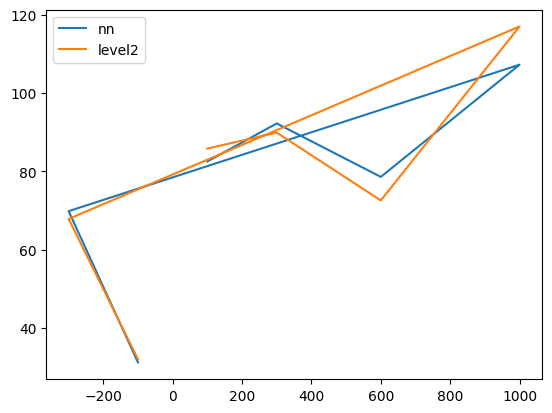

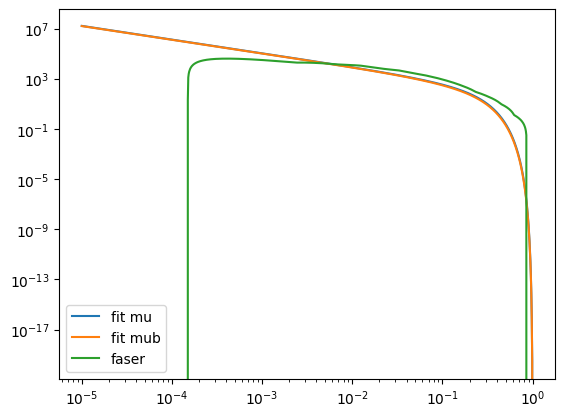

counter = 0


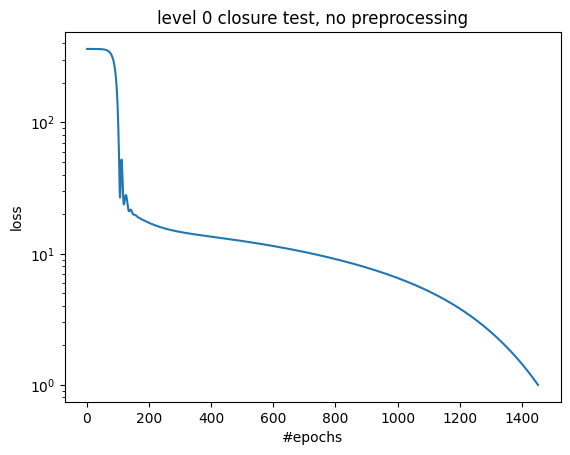

tensor([187429.7344], grad_fn=<SelectBackward0>)
tensor([180722.7969], grad_fn=<SelectBackward0>)
-1.25256753545764 19.671753945065234 13.458223107716504
tensor(344.5695, grad_fn=<AddBackward0>)
tensor(344.5691, grad_fn=<AddBackward0>)
tensor(344.5686, grad_fn=<AddBackward0>)
tensor(344.5682, grad_fn=<AddBackward0>)
tensor(344.5677, grad_fn=<AddBackward0>)
tensor(344.5672, grad_fn=<AddBackward0>)
tensor(344.5667, grad_fn=<AddBackward0>)
tensor(344.5661, grad_fn=<AddBackward0>)
tensor(344.5656, grad_fn=<AddBackward0>)
tensor(344.5649, grad_fn=<AddBackward0>)
tensor(344.5643, grad_fn=<AddBackward0>)
tensor(344.5636, grad_fn=<AddBackward0>)
tensor(344.5629, grad_fn=<AddBackward0>)
tensor(344.5621, grad_fn=<AddBackward0>)
tensor(344.5613, grad_fn=<AddBackward0>)
tensor(344.5605, grad_fn=<AddBackward0>)
tensor(344.5597, grad_fn=<AddBackward0>)
tensor(344.5587, grad_fn=<AddBackward0>)
tensor(344.5578, grad_fn=<AddBackward0>)
tensor(344.5568, grad_fn=<AddBackward0>)
tensor(344.5557, grad_fn=<

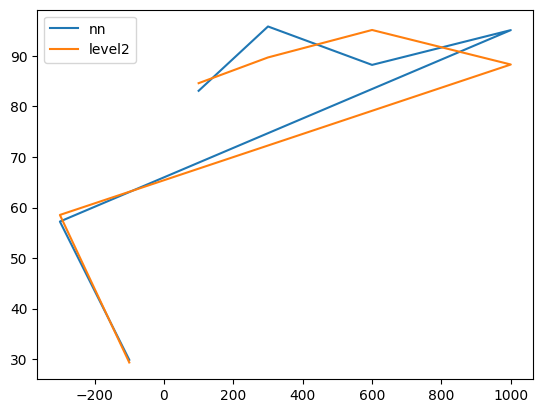

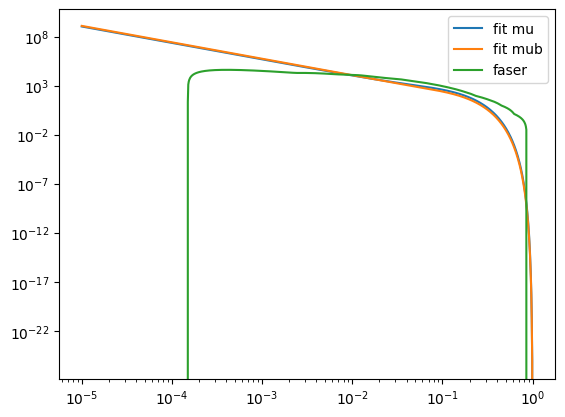

counter = 0


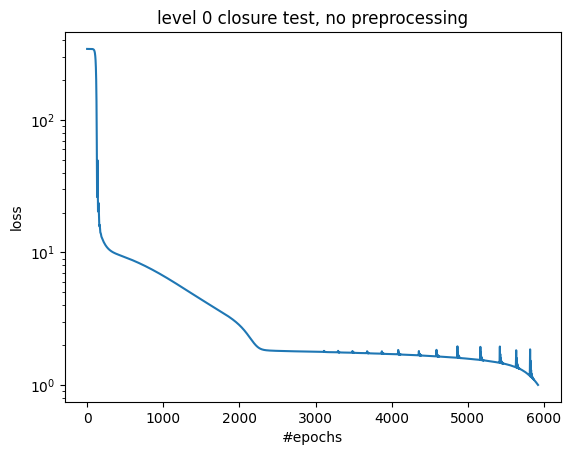

tensor([1100805.7500], grad_fn=<SelectBackward0>)
tensor([1263333.7500], grad_fn=<SelectBackward0>)
0.8698463945322059 5.338786613619597 70.4665101413468
tensor(267.4520, grad_fn=<AddBackward0>)
tensor(264.7453, grad_fn=<AddBackward0>)
tensor(261.9469, grad_fn=<AddBackward0>)
tensor(259.0545, grad_fn=<AddBackward0>)
tensor(256.0659, grad_fn=<AddBackward0>)
tensor(252.9795, grad_fn=<AddBackward0>)
tensor(249.7937, grad_fn=<AddBackward0>)
tensor(246.5076, grad_fn=<AddBackward0>)
tensor(243.1209, grad_fn=<AddBackward0>)
tensor(239.6340, grad_fn=<AddBackward0>)
tensor(236.0482, grad_fn=<AddBackward0>)
tensor(232.3659, grad_fn=<AddBackward0>)
tensor(228.5910, grad_fn=<AddBackward0>)
tensor(224.7289, grad_fn=<AddBackward0>)
tensor(220.7871, grad_fn=<AddBackward0>)
tensor(216.7751, grad_fn=<AddBackward0>)
tensor(212.7057, grad_fn=<AddBackward0>)
tensor(208.5941, grad_fn=<AddBackward0>)
tensor(204.4596, grad_fn=<AddBackward0>)
tensor(200.3254, grad_fn=<AddBackward0>)
tensor(196.2190, grad_fn=<

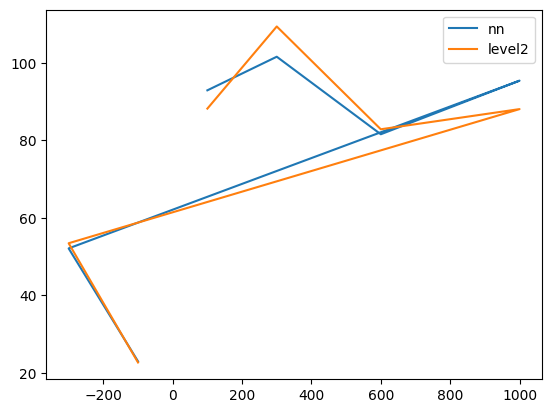

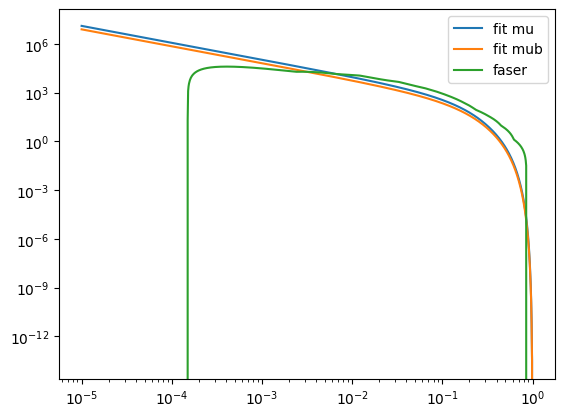

counter = 0


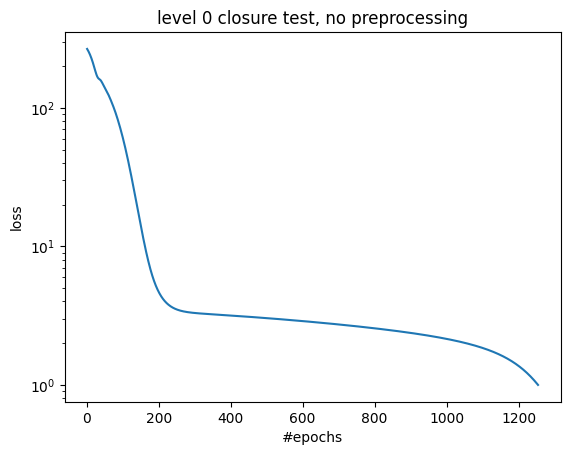

tensor([183456.1562], grad_fn=<SelectBackward0>)
tensor([111987.6562], grad_fn=<SelectBackward0>)
-4.67406949471396 9.628879440562233 0.28786217884702037
tensor(415.9112, grad_fn=<AddBackward0>)
tensor(415.9112, grad_fn=<AddBackward0>)
tensor(415.9112, grad_fn=<AddBackward0>)
tensor(415.9112, grad_fn=<AddBackward0>)
tensor(415.9112, grad_fn=<AddBackward0>)
tensor(415.9112, grad_fn=<AddBackward0>)
tensor(415.9112, grad_fn=<AddBackward0>)
tensor(415.9112, grad_fn=<AddBackward0>)
tensor(415.9112, grad_fn=<AddBackward0>)
tensor(415.9112, grad_fn=<AddBackward0>)
tensor(415.9112, grad_fn=<AddBackward0>)
tensor(415.9112, grad_fn=<AddBackward0>)
tensor(415.9112, grad_fn=<AddBackward0>)
tensor(415.9112, grad_fn=<AddBackward0>)
tensor(415.9112, grad_fn=<AddBackward0>)
tensor(415.9112, grad_fn=<AddBackward0>)
tensor(415.9112, grad_fn=<AddBackward0>)
tensor(415.9112, grad_fn=<AddBackward0>)
tensor(415.9112, grad_fn=<AddBackward0>)
tensor(415.9112, grad_fn=<AddBackward0>)
tensor(415.9112, grad_fn=<

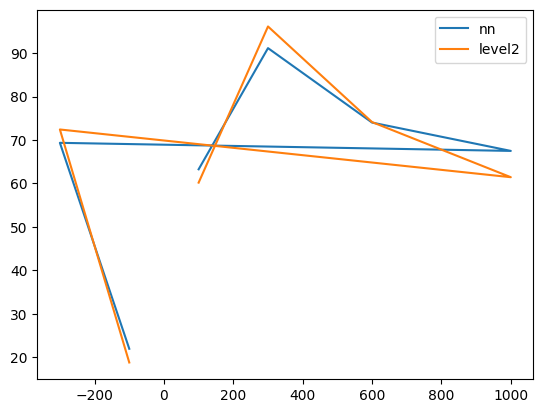

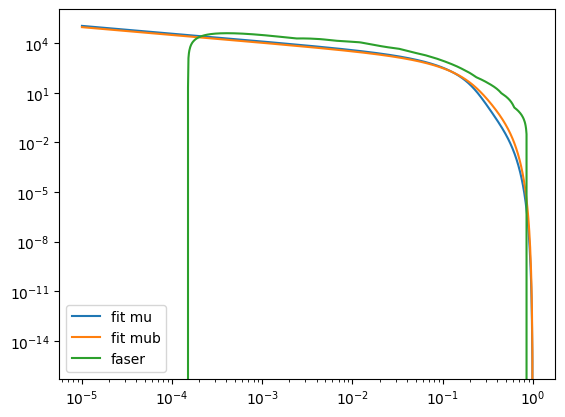

counter = 0


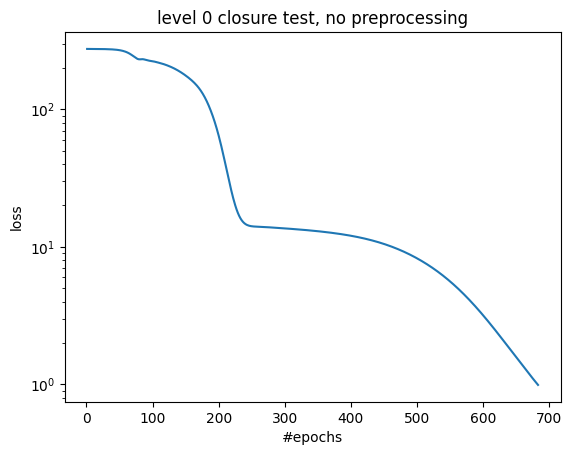

tensor([16289.9453], grad_fn=<SelectBackward0>)
tensor([13632.2852], grad_fn=<SelectBackward0>)
0.9437092565753771 3.232063129648349 30.385262709072947
tensor(344.4294, grad_fn=<AddBackward0>)
tensor(342.6686, grad_fn=<AddBackward0>)
tensor(340.8405, grad_fn=<AddBackward0>)
tensor(338.9421, grad_fn=<AddBackward0>)
tensor(336.9704, grad_fn=<AddBackward0>)
tensor(334.9223, grad_fn=<AddBackward0>)
tensor(332.7945, grad_fn=<AddBackward0>)
tensor(330.5834, grad_fn=<AddBackward0>)
tensor(328.2855, grad_fn=<AddBackward0>)
tensor(325.8970, grad_fn=<AddBackward0>)
tensor(323.4143, grad_fn=<AddBackward0>)
tensor(320.8333, grad_fn=<AddBackward0>)
tensor(318.1497, grad_fn=<AddBackward0>)
tensor(315.3596, grad_fn=<AddBackward0>)
tensor(312.4582, grad_fn=<AddBackward0>)
tensor(309.4410, grad_fn=<AddBackward0>)
tensor(306.3030, grad_fn=<AddBackward0>)
tensor(303.0389, grad_fn=<AddBackward0>)
tensor(299.6429, grad_fn=<AddBackward0>)
tensor(296.1088, grad_fn=<AddBackward0>)
tensor(292.4303, grad_fn=<Ad

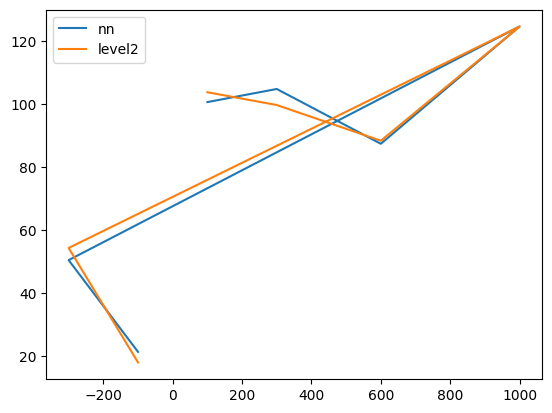

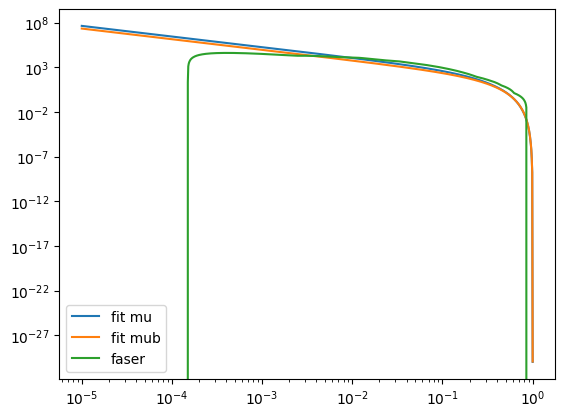

counter = 0


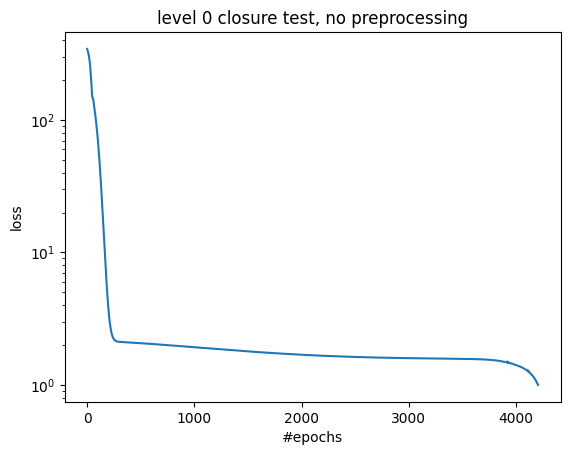

tensor([329771.], grad_fn=<SelectBackward0>)
tensor([165482.5469], grad_fn=<SelectBackward0>)
-1.1800281157663104 16.161842131283137 5.887056437810456
tensor(334.0821, grad_fn=<AddBackward0>)
tensor(334.0815, grad_fn=<AddBackward0>)
tensor(334.0807, grad_fn=<AddBackward0>)
tensor(334.0800, grad_fn=<AddBackward0>)
tensor(334.0792, grad_fn=<AddBackward0>)
tensor(334.0784, grad_fn=<AddBackward0>)
tensor(334.0775, grad_fn=<AddBackward0>)
tensor(334.0766, grad_fn=<AddBackward0>)
tensor(334.0756, grad_fn=<AddBackward0>)
tensor(334.0746, grad_fn=<AddBackward0>)
tensor(334.0736, grad_fn=<AddBackward0>)
tensor(334.0724, grad_fn=<AddBackward0>)
tensor(334.0713, grad_fn=<AddBackward0>)
tensor(334.0700, grad_fn=<AddBackward0>)
tensor(334.0688, grad_fn=<AddBackward0>)
tensor(334.0674, grad_fn=<AddBackward0>)
tensor(334.0659, grad_fn=<AddBackward0>)
tensor(334.0644, grad_fn=<AddBackward0>)
tensor(334.0627, grad_fn=<AddBackward0>)
tensor(334.0609, grad_fn=<AddBackward0>)
tensor(334.0591, grad_fn=<Add

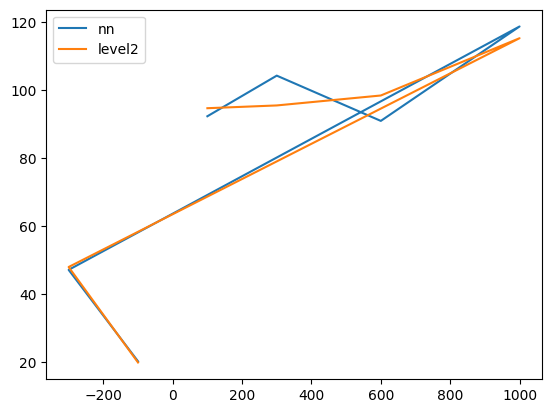

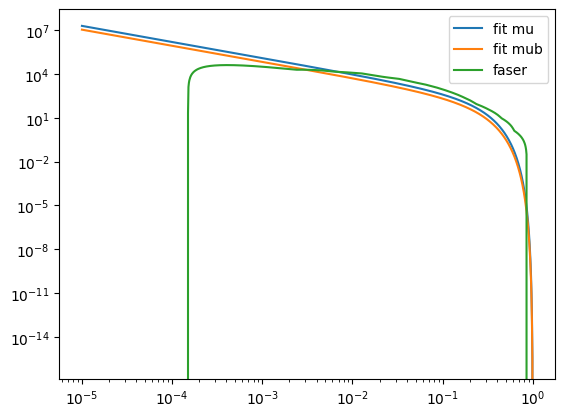

counter = 50


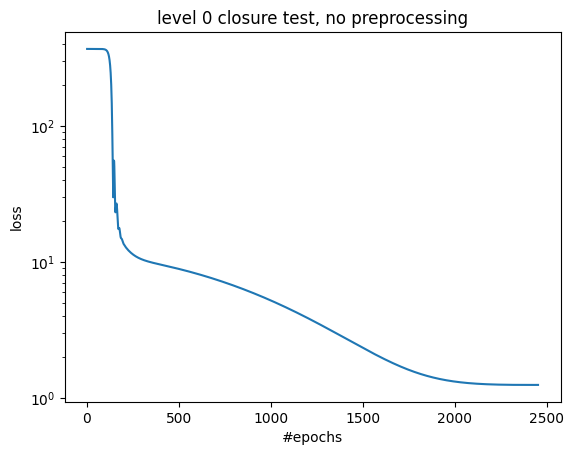

tensor([214104.6094], grad_fn=<SelectBackward0>)
tensor([117917.7656], grad_fn=<SelectBackward0>)
-2.002057631564905 -19.23897519624875 56.52666769162741
tensor(nan, grad_fn=<AddBackward0>)
NaN detected in gradients of preprocessing.alpha!
tensor([4.8726e-05, 3.3288e-03, 1.2202e-01, 1.1992e+02, 4.9487e-02, 1.7052e-05],
       grad_fn=<CatBackward0>)
NaN detected in gradients of preprocessing.beta!
tensor([4.8726e-05, 3.3288e-03, 1.2202e-01, 1.1992e+02, 4.9487e-02, 1.7052e-05],
       grad_fn=<CatBackward0>)
NaN detected in gradients of preprocessing.gamma!
tensor([4.8726e-05, 3.3288e-03, 1.2202e-01, 1.1992e+02, 4.9487e-02, 1.7052e-05],
       grad_fn=<CatBackward0>)
NaN detected in gradients of mlp.linear.weight!
tensor([4.8726e-05, 3.3288e-03, 1.2202e-01, 1.1992e+02, 4.9487e-02, 1.7052e-05],
       grad_fn=<CatBackward0>)
NaN detected in gradients of mlp.linear.bias!
tensor([4.8726e-05, 3.3288e-03, 1.2202e-01, 1.1992e+02, 4.9487e-02, 1.7052e-05],
       grad_fn=<CatBackward0>)
NaN det

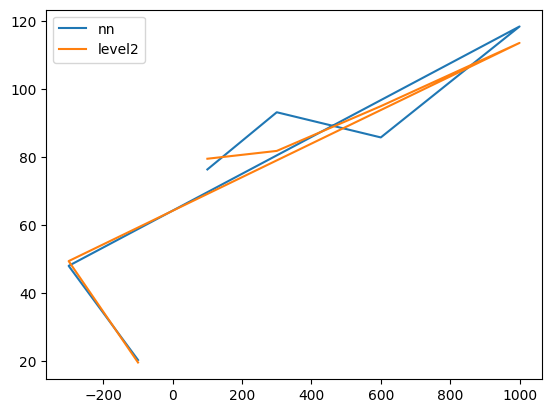

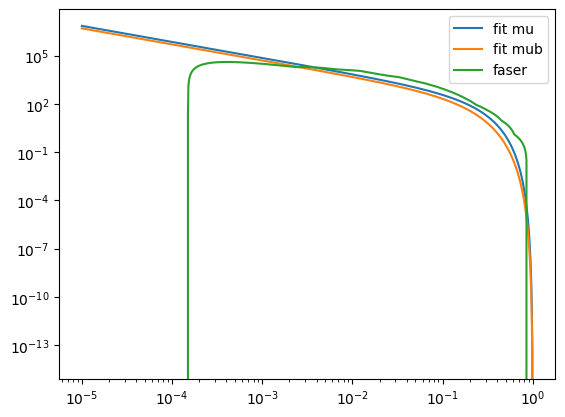

counter = 50


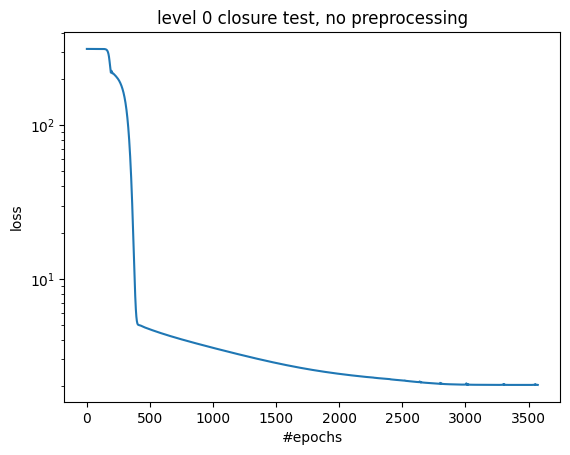

tensor([120154.6406], grad_fn=<SelectBackward0>)
tensor([84061.1094], grad_fn=<SelectBackward0>)
-0.07629567812068316 -2.933592129611867 62.42163518382247
tensor(330.0683, grad_fn=<AddBackward0>)
tensor(329.5073, grad_fn=<AddBackward0>)
tensor(328.9387, grad_fn=<AddBackward0>)
tensor(328.3633, grad_fn=<AddBackward0>)
tensor(327.7820, grad_fn=<AddBackward0>)
tensor(327.1958, grad_fn=<AddBackward0>)
tensor(326.6061, grad_fn=<AddBackward0>)
tensor(326.0143, grad_fn=<AddBackward0>)
tensor(325.4222, grad_fn=<AddBackward0>)
tensor(324.8319, grad_fn=<AddBackward0>)
tensor(324.2457, grad_fn=<AddBackward0>)
tensor(323.6663, grad_fn=<AddBackward0>)
tensor(323.0966, grad_fn=<AddBackward0>)
tensor(322.5403, grad_fn=<AddBackward0>)
tensor(322.0008, grad_fn=<AddBackward0>)
tensor(321.4824, grad_fn=<AddBackward0>)
tensor(320.9893, grad_fn=<AddBackward0>)
tensor(320.5261, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)

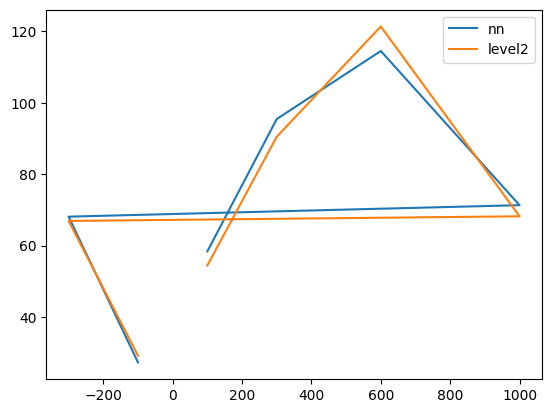

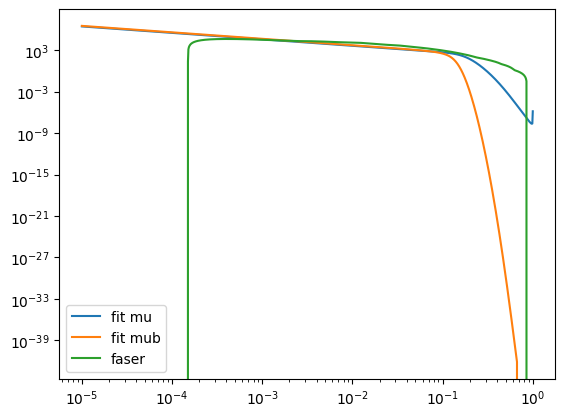

counter = 0


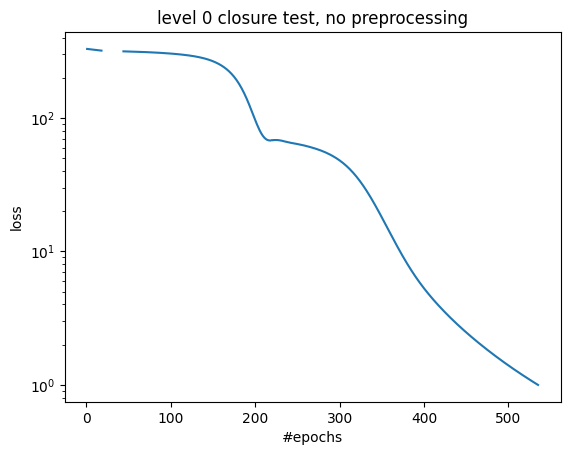

tensor([58960.3711], grad_fn=<SelectBackward0>)
tensor([70554.9062], grad_fn=<SelectBackward0>)
-0.8565333275427722 -12.343364523973971 69.00353852395597
tensor(nan, grad_fn=<AddBackward0>)
NaN detected in gradients of preprocessing.alpha!
tensor([3.7965e-03, 8.5889e-02, 1.1358e+00, 1.7517e+02, 6.6736e-01, 1.8360e-03],
       grad_fn=<CatBackward0>)
NaN detected in gradients of preprocessing.beta!
tensor([3.7965e-03, 8.5889e-02, 1.1358e+00, 1.7517e+02, 6.6736e-01, 1.8360e-03],
       grad_fn=<CatBackward0>)
NaN detected in gradients of preprocessing.gamma!
tensor([3.7965e-03, 8.5889e-02, 1.1358e+00, 1.7517e+02, 6.6736e-01, 1.8360e-03],
       grad_fn=<CatBackward0>)
NaN detected in gradients of mlp.linear.weight!
tensor([3.7965e-03, 8.5889e-02, 1.1358e+00, 1.7517e+02, 6.6736e-01, 1.8360e-03],
       grad_fn=<CatBackward0>)
NaN detected in gradients of mlp.linear.bias!
tensor([3.7965e-03, 8.5889e-02, 1.1358e+00, 1.7517e+02, 6.6736e-01, 1.8360e-03],
       grad_fn=<CatBackward0>)
NaN det

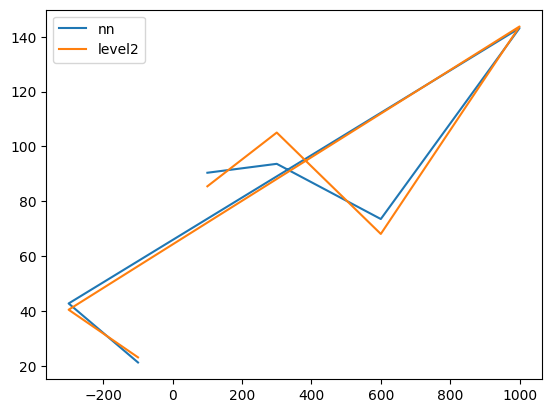

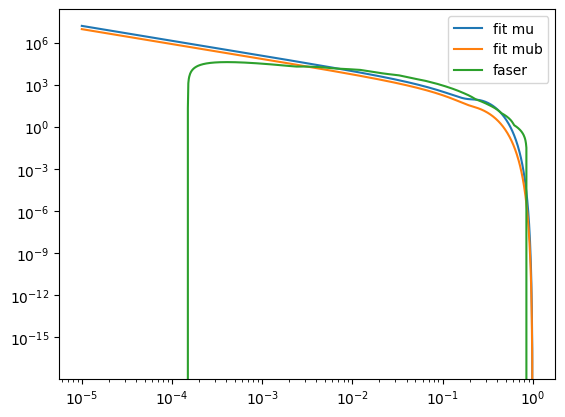

counter = 50


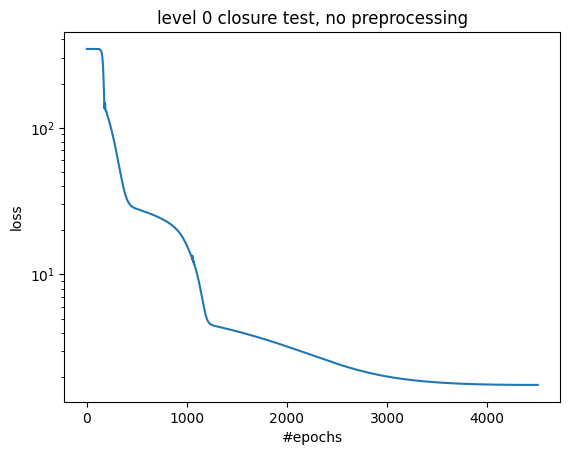

tensor([199417.9219], grad_fn=<SelectBackward0>)
tensor([116861.6016], grad_fn=<SelectBackward0>)
-1.00275607509115 -4.210724113176223 94.46159034942536
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn

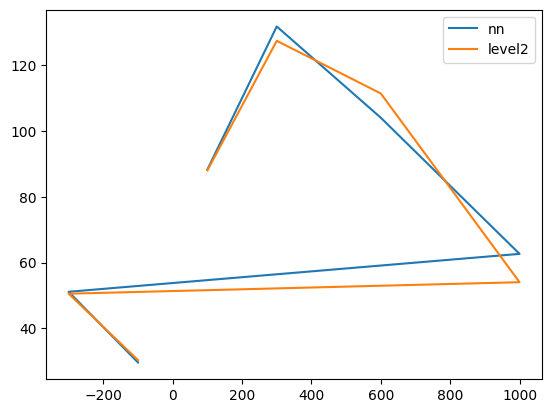

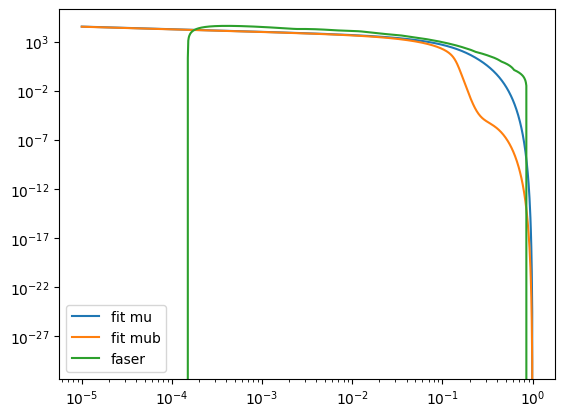

counter = 0


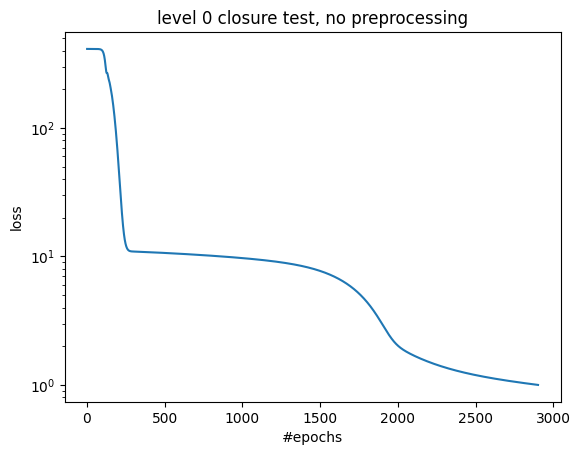

tensor([11499.9023], grad_fn=<SelectBackward0>)
tensor([11142.2969], grad_fn=<SelectBackward0>)
-3.702583140493073 12.07640783963236 24.541019619947235
tensor(379.9272, grad_fn=<AddBackward0>)
tensor(379.9272, grad_fn=<AddBackward0>)
tensor(379.9272, grad_fn=<AddBackward0>)
tensor(379.9271, grad_fn=<AddBackward0>)
tensor(379.9271, grad_fn=<AddBackward0>)
tensor(379.9271, grad_fn=<AddBackward0>)
tensor(379.9271, grad_fn=<AddBackward0>)
tensor(379.9271, grad_fn=<AddBackward0>)
tensor(379.9271, grad_fn=<AddBackward0>)
tensor(379.9271, grad_fn=<AddBackward0>)
tensor(379.9271, grad_fn=<AddBackward0>)
tensor(379.9271, grad_fn=<AddBackward0>)
tensor(379.9271, grad_fn=<AddBackward0>)
tensor(379.9271, grad_fn=<AddBackward0>)
tensor(379.9271, grad_fn=<AddBackward0>)
tensor(379.9270, grad_fn=<AddBackward0>)
tensor(379.9270, grad_fn=<AddBackward0>)
tensor(379.9270, grad_fn=<AddBackward0>)
tensor(379.9270, grad_fn=<AddBackward0>)
tensor(379.9270, grad_fn=<AddBackward0>)
tensor(379.9270, grad_fn=<Ad

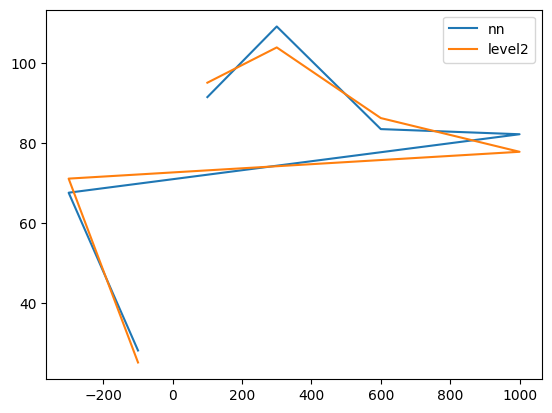

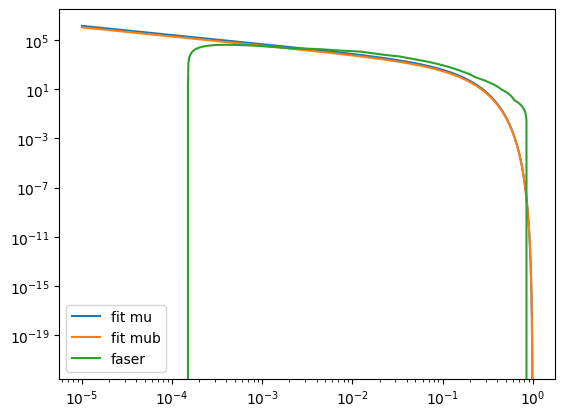

counter = 50


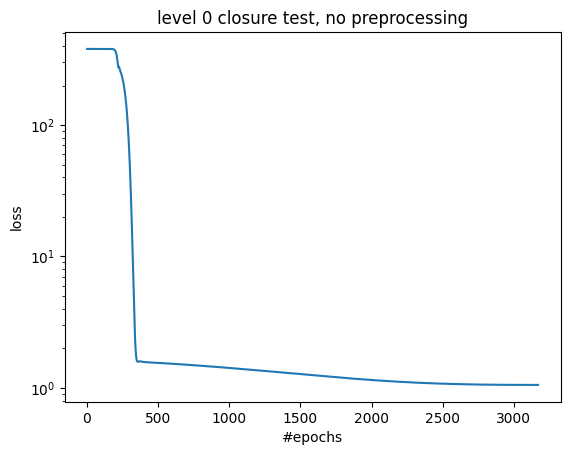

tensor([65685.9141], grad_fn=<SelectBackward0>)
tensor([49782.1992], grad_fn=<SelectBackward0>)


In [18]:
chi_squares,N_event_pred, neutrino_pdfs_mu,neutrino_pdfs_mub,model = perform_fit(pred,REPLICAS)

In [19]:
closure_fit = Postfit()
# neutrino_pdfs, N_event_pred = closure_fit.apply_postfit_criteria(chi_squares,N_event_pred,neutrino_pdfs)

In [20]:
x_vals = x_vals.detach().numpy().flatten()
pdf = "FASERv_EPOS+POWHEG_7TeV"
print(pdf)
faser_pdf_mu,x_faser = read_pdf(pdf,x_vals,14) 
faser_pdf_mub,x_faser = read_pdf(pdf,x_vals,-14)
# mean_fnu = np.mean(neutrino_pdfs,axis=0) *x_vals
mean_fnu_mu = np.mean(neutrino_pdfs_mu,axis=0) 
mean_fnu_mub = np.mean(neutrino_pdfs_mub,axis=0) 

mean_pdf_preproc = np.mean(preproc_pdfs,axis=0) 
mean_nn_pdf = np.mean(nn_pdfs,axis=0) 

FASERv_EPOS+POWHEG_7TeV
LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/FASERv_EPOS+POWHEG_7TeV/FASERv_EPOS+POWHEG_7TeV_0000.dat
FASERv_EPOS+POWHEG_7TeV PDF set, member #0, version 1; LHAPDF ID = 70001000
LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/FASERv_EPOS+POWHEG_7TeV/FASERv_EPOS+POWHEG_7TeV_0000.dat
FASERv_EPOS+POWHEG_7TeV PDF set, member #0, version 1; LHAPDF ID = 70001000


In [21]:
# from lhapdf_grid import write_lhapdf_grid
# mean_fnu = np.mean(neutrino_pdfs, axis=0) * x_vals
# lhapdfpath = '/opt/anaconda3/envs/nnpdf_dev/share/LHAPDF/enu/enu_0000.dat'

# write_lhapdf_grid(x_vals,mean_fnu,lhapdfpath)

/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_80194/1462515609.py:15: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.plot(x_vals,mean_fnu_mu,'o',label=r"$f_{\mathrm{fit}}$",markersize=1.5)


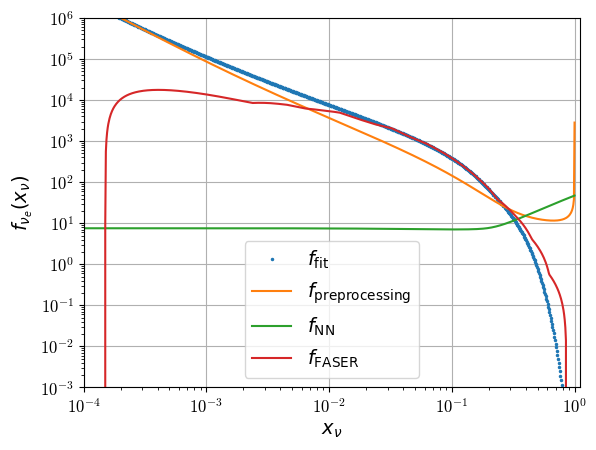

In [22]:
# plt.plot(cont_x,mean_pdf_preproc*mean_nn_pdf*(x_alpha_more_bins.detach().numpy().flatten()),label = 'mult' )
# lowx = -8
# n=250
# x_vals = generate_grid(lowx,n)

plt.rcParams.update(
    {
        "font.family": "serif",
        "font.serif": ["cmr10"],  # Computer Modern
    }
)


x_vals = torch.tensor(x_vals, dtype=torch.float32).view(-1,1)
plt.plot(x_vals,mean_fnu_mu,'o',label=r"$f_{\mathrm{fit}}$",markersize=1.5)
plt.plot(x_vals,mean_pdf_preproc,label=r"$f_{\mathrm{preprocessing}}$",markersize=1.5)
plt.plot(x_vals,mean_nn_pdf,label=r"$f_{\mathrm{NN}}$",markersize=1.5)
# plt.axvline(x=min(xvals_per_obs[0])/14000, color='green', linestyle='--', label='no data to the left of this line')
plt.plot(x_faser,faser_pdf_mu* 65.6/150,label =r"$f_{\mathrm{FASER}}$")
plt.xlabel(r"$x_{\nu}$",fontsize = 14)
plt.ylabel(r"$f_{\nu_e}(x_{\nu})$",fontsize = 14)
plt.ylim(10**-3,10**6)
plt.xlim(10**-4,1.1)
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.legend(fontsize=14)
# plt.legend()
plt.savefig('preprocbeast.pdf')
plt.show()




/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_80194/2719966959.py:2: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.plot(x_vals,mean_fnu_mub,'o',label="fnu mub",markersize=1.5)


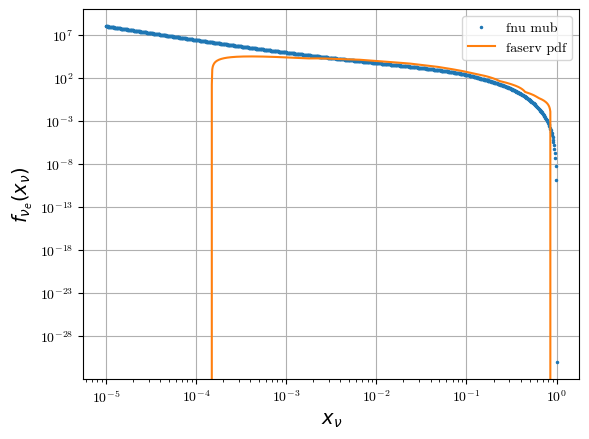

In [23]:
# plt.plot(cont_x,mean_pdf_preproc*mean_nn_pdf*(x_alpha_more_bins.detach().numpy().flatten()),label = 'mult' )
plt.plot(x_vals,mean_fnu_mub,'o',label="fnu mub",markersize=1.5)
# plt.plot(x_vals,mean_pdf_preproc,label="fpreproc",markersize=1.5)
# plt.plot(x_vals,mean_nn_pdf,label="fnn",markersize=1.5)
# plt.axvline(x=min(xvals_per_obs[0])/14000, color='green', linestyle='--', label='no data to the left of this line')
plt.plot(x_faser,faser_pdf_mub,label ='faserv pdf')
plt.xlabel(r"$x_{\nu}$",fontsize = 14)
plt.ylabel(r"$f_{\nu_e}(x_{\nu})$",fontsize = 14)
# plt.ylim(10**-3,10**6)
# plt.xlim(10**-4,1.1)
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/FASERv_EPOS+POWHEG_7TeV/FASERv_EPOS+POWHEG_7TeV_0000.dat
FASERv_EPOS+POWHEG_7TeV PDF set, member #0, version 1; LHAPDF ID = 70001000
LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/FASERv_EPOS+POWHEG_7TeV/FASERv_EPOS+POWHEG_7TeV_0000.dat
FASERv_EPOS+POWHEG_7TeV PDF set, member #0, version 1; LHAPDF ID = 70001000
[ 78.29619  102.282326  88.811775 108.44622   55.481354  24.218927
  24.218927]
[ 83.139305 100.767426  87.86494  101.20249   55.774933  24.833735
  24.833735]


/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_80194/1145613666.py:53: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  axL = fig.add_subplot(gs[0, 0])
/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_80194/1145613666.py:54: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  axR = fig.add_subplot(gs[0, 1])
/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_80194/1145613666.py:55: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  axrL = fig.add_subplot(gs[1, 0])
/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_80194/1145613666.py:56: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  axrR = fig.add_subplot(gs[1, 1])
/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_80194/1145613666.py:147: RuntimeWarning: divide by zero encount

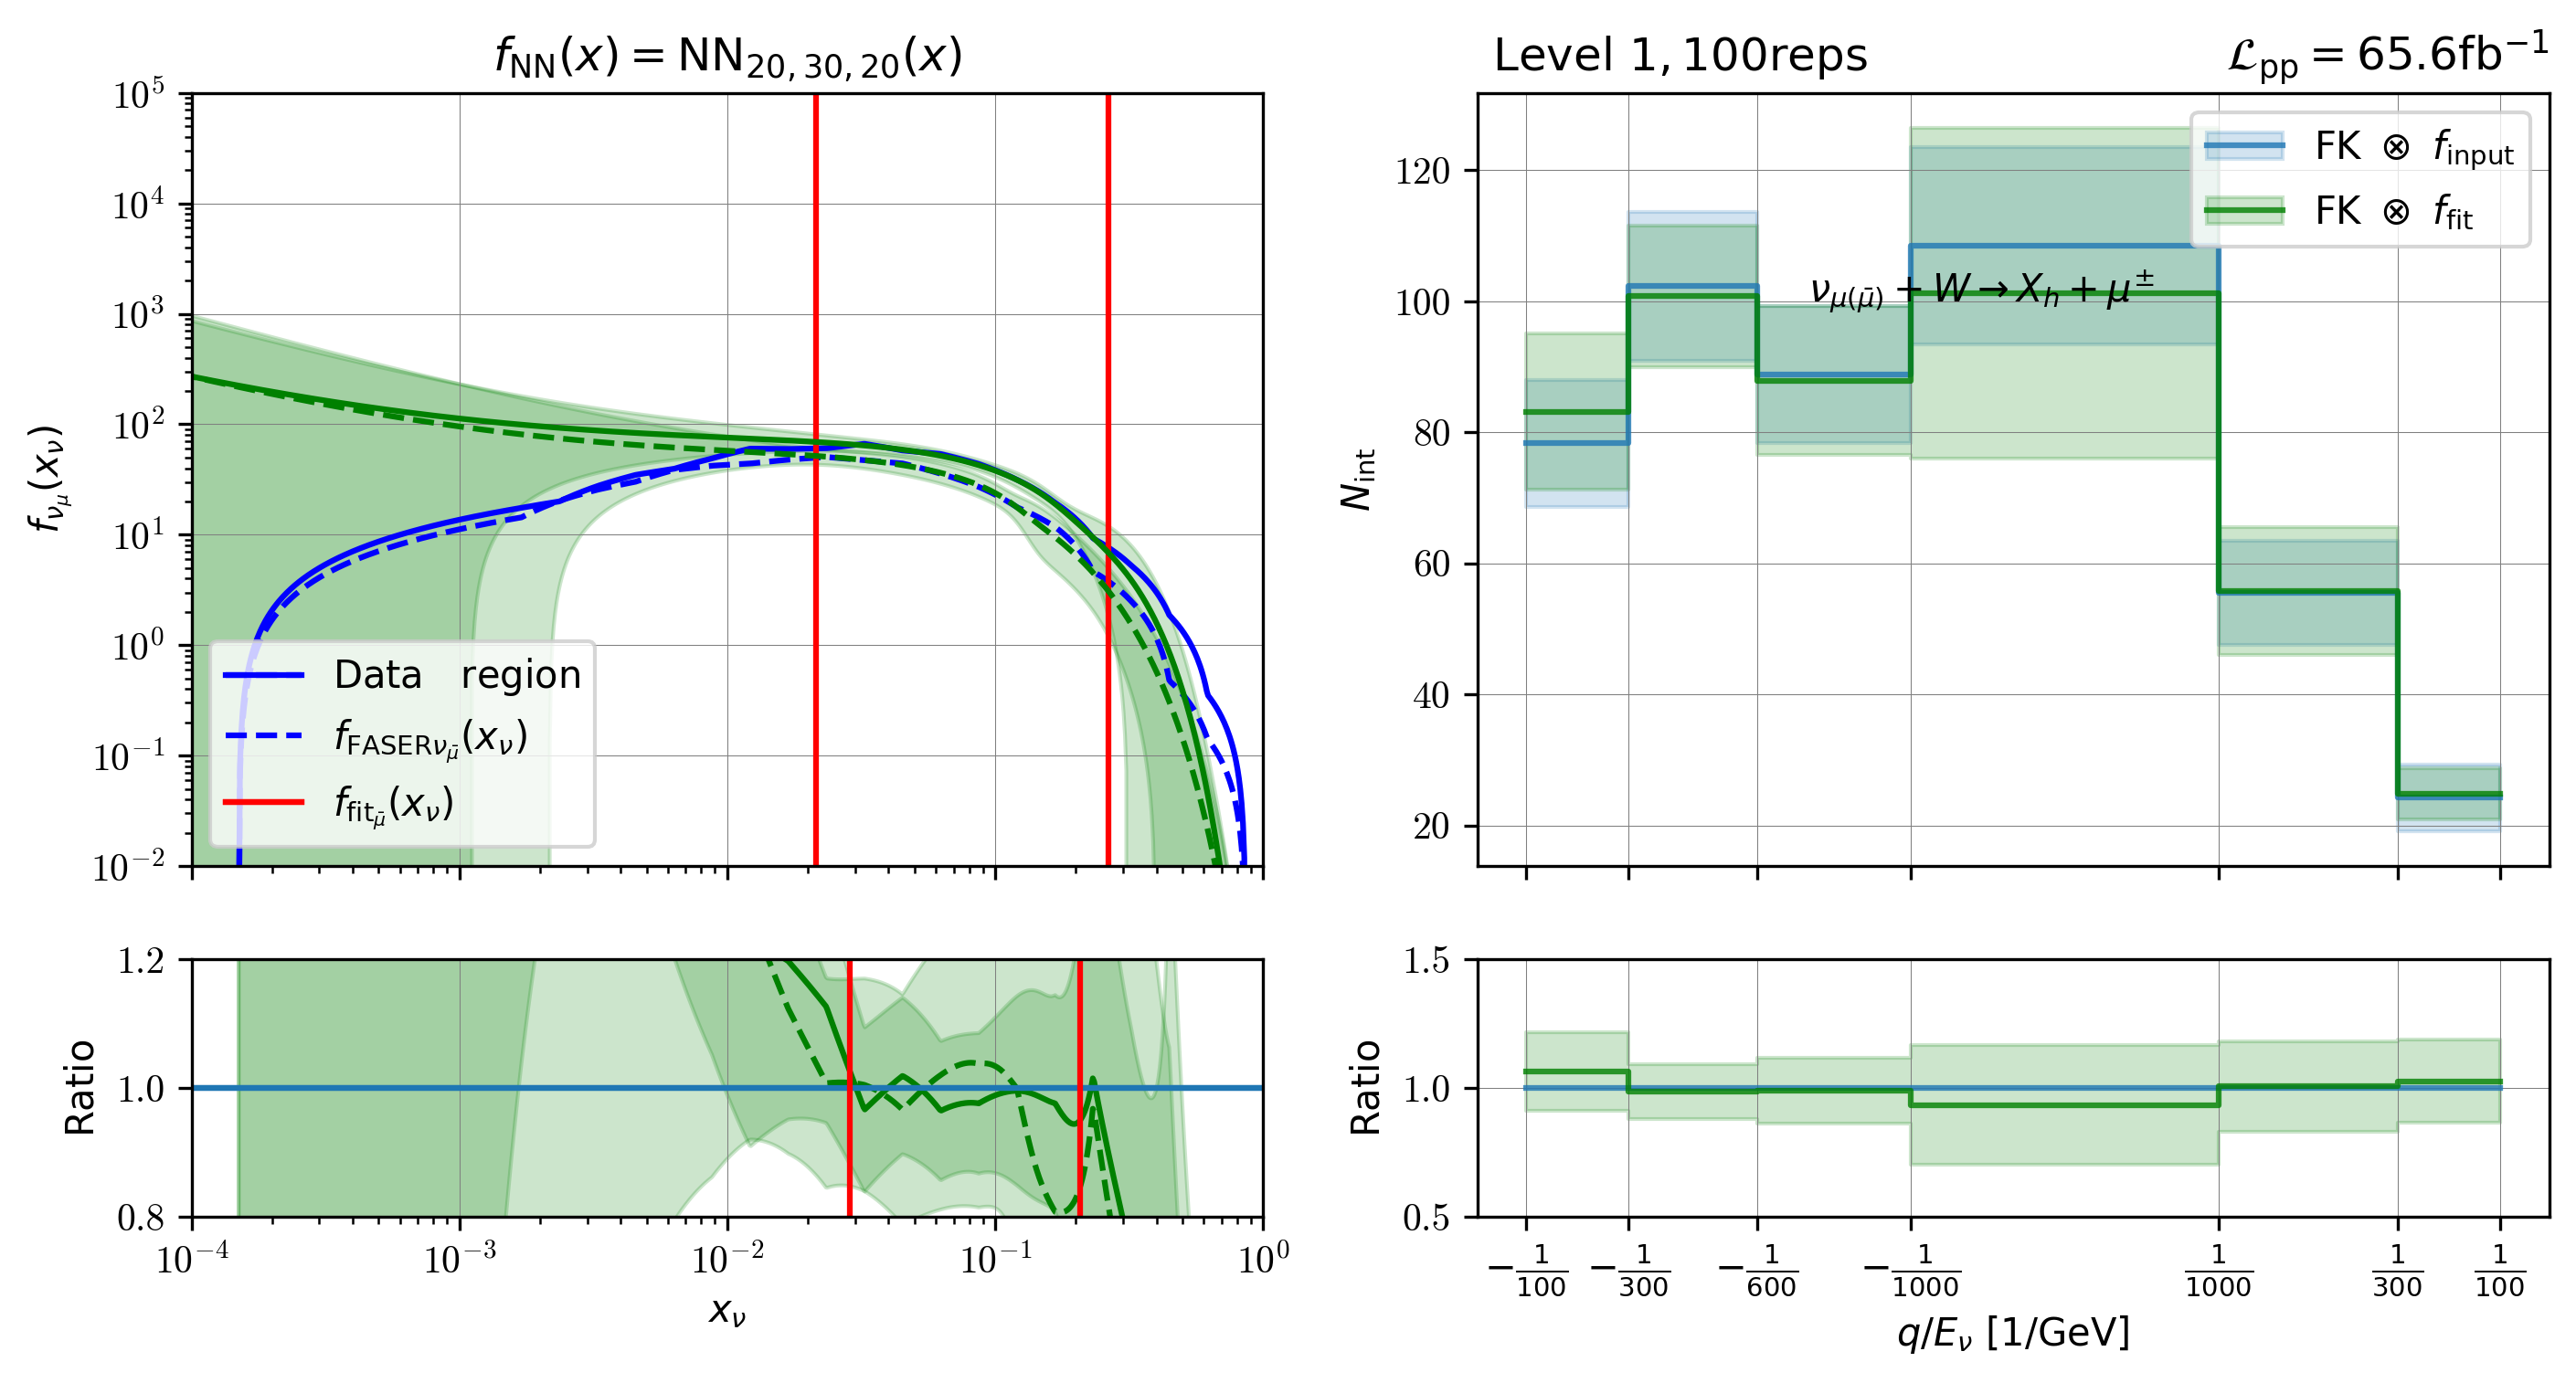

In [27]:
from matplotlib.legend_handler import HandlerTuple
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
from read_faserv_pdf import read_pdf

# Data for plot
import matplotlib.ticker as ticker


def plot_seperate(
    x_vals,
    neutrino_pdfs_mu,
    neutrino_pdfs_mub,
    level0,
    N_event_pred,
    sig_tot,
    xvals_per_obs,
    pid,
):
    pdf = "FASERv_EPOS+POWHEG_7TeV"
    # pdf = "faserv"
    faser_pdf_mu, x_faser = read_pdf(pdf, x_vals, 14)
    faser_pdf_mub, x_faser = read_pdf(pdf, x_vals, -14)
    faser_pdf_mu = faser_pdf_mu * 65.6/150 * x_vals
    faser_pdf_mub = faser_pdf_mub * 65.6/150* x_vals
    mean_fnu_mu = np.mean(neutrino_pdfs_mu, axis=0)* x_vals
    error_fnu_mu = np.std(neutrino_pdfs_mu, axis=0)* x_vals

    mean_fnu_mub = np.mean(neutrino_pdfs_mub, axis=0)* x_vals
    error_fnu_mub = np.std(neutrino_pdfs_mub, axis=0)* x_vals

    simulated_Enu = level0[0]
    preds_Enu = np.mean(N_event_pred, axis=0)
    pred_stds_Enu = np.std(N_event_pred, axis=0)
    # errors_enu = [5186, 6239, 4165, 1738, 622, 847]
    # errors_enu = np.array(errors_enu)
    # errors_enu = np.sqrt(level0[0])
    errors_enu = sig_tot

    xvals_per_obs = np.append(xvals_per_obs, 1900)
    simulated_Enu = np.append(simulated_Enu, simulated_Enu[-1])
    print(simulated_Enu)
    preds_Enu = np.append(preds_Enu, preds_Enu[-1])
    print(preds_Enu)
    pred_stds_Enu = np.append(pred_stds_Enu, pred_stds_Enu[-1])
    errors_enu = np.append(errors_enu, errors_enu[-1])
    # fig = plt.figure(figsize=(6.8, 3.4), dpi=300)  # 2 rows, 2 columns
    fig = plt.figure(figsize=(10, 5), dpi=300)
    gs = gridspec.GridSpec(2, 2, height_ratios=[3, 1])
    gs.update(left=0.09, right=0.95, top=0.93, hspace=0.18)

    axL = fig.add_subplot(gs[0, 0])
    axR = fig.add_subplot(gs[0, 1])
    axrL = fig.add_subplot(gs[1, 0])
    axrR = fig.add_subplot(gs[1, 1])

    # ======== TOP LEFT (Main plot, f_NN vs f_FASERv ) =============
    (axLsim_mu,) = axL.plot(
        x_vals,
        faser_pdf_mu,
        linestyle="-",
        color="b",
        label=r"$f_{\mathrm{FASER}\nu_\mu}(x_\nu)$",
    )

    (axLsim_mub,) = axL.plot(
        x_vals,
        faser_pdf_mub,
        linestyle="--",
        color="b",
        label=r"$f_{\mathrm{FASER}\nu_{\bar{\mu}}}(x_\nu)$",
    )

    axLvert1 = axL.axvline(x=150 / 7000, color="red", label="axvline - full height")
    axLvert2 = axL.axvline(x=1850 / 7000, color="red", label="axvline - full height")
    axLnnerr_mu = axL.fill_between(
        x_vals,
        (mean_fnu_mu + error_fnu_mu),
        (mean_fnu_mu - error_fnu_mu),
        color="green",
        alpha=0.2,
        label=r"$\pm 1\sigma$",
    )

    axLnnerr_mub = axL.fill_between(
        x_vals,
        (mean_fnu_mub + error_fnu_mub),
        (mean_fnu_mub - error_fnu_mub),
        color="green",
        alpha=0.2,
        label=r"$\pm 1\sigma$",
    )

    (axLnn_mu,) = axL.plot(
        x_vals,
        mean_fnu_mu,
        linestyle="-",
        color="green",
        label=r"$f_{\mathrm{fit}\mu}(x)$",
    )

    (axLnn_mub,) = axL.plot(
        x_vals,
        mean_fnu_mub,
        linestyle="--",
        color="green",
        label=r"$f_{\mathrm{fit}\bar{\mu}}(x)$",
    )

    axL.set_xlim(1e-4, 1)
    axL.set_ylim(1e-2, 1e5)
    axL.set_yscale("log")
    axL.set_xscale("log")
    axL.set_title(
        # r"$f_{\mathrm{NN}}(x) = \mathcal{A} \ x^{1-\alpha}(1-x)^\beta \ \mathrm{NN}(x)$"
        r"$f_{\mathrm{NN}}(x) = \mathrm{NN_{20,30,20}}(x)$"
    )
    axL.set_ylabel(r"$f_{\nu_\mu}(x_\nu)$")
    axL.set_xticklabels([])
    axL.grid(color="grey", linestyle="-", linewidth=0.25)
    axL.yaxis.set_minor_locator(
        ticker.LogLocator(base=10.0, subs=np.arange(1.0, 10.0) * 0.1, numticks=10)
    )
    axL.legend(
        [
            (axLsim_mu, axLsim_mub),
            (axLsim_mub),
            (axLvert1, axLvert2),
            (axLsim_mub),
            (axLnn_mu, axLnnerr_mu),
            (axLnn_mub, axLnnerr_mub),
        ],
        [
            # r"$f_{\mathrm{FASER}\nu_\mu}(x_\nu)$",
            r"$\mathrm{Data}\quad\mathrm{region}$",
            r"$f_{\mathrm{FASER}\nu_{\bar{\mu}}}(x_\nu)$",
            # r"$f_{\mathrm{fit}_\mu}(x_\nu)$",
            r"$f_{\mathrm{fit}_{\bar{\mu}}}(x_\nu)$",
        ],
        handler_map={tuple: HandlerTuple(ndivide=1)},
        loc="lower left",
    ).set_alpha(0.8)

    # ========== BOTTOM LEFT (Ratio plot, f_NN vs f_FASERv )

    ratio_center = mean_fnu_mu / faser_pdf_mu
    ratio_lower = (mean_fnu_mu - error_fnu_mu) / faser_pdf_mu
    ratio_upper = (mean_fnu_mu + error_fnu_mu) / faser_pdf_mu

    axrL.plot(x_vals, ratio_center, linestyle="-", color="green")
    axrL.fill_between(x_vals, ratio_upper, ratio_lower, color="green", alpha=0.2)
    axrL.plot(x_vals, np.ones(len(x_vals)), linestyle="-", color="tab:blue")

    ratio_center = mean_fnu_mub / faser_pdf_mub
    ratio_lower = (mean_fnu_mub - error_fnu_mub) / faser_pdf_mub
    ratio_upper = (mean_fnu_mub + error_fnu_mub) / faser_pdf_mub

    axrL.plot(x_vals, ratio_center, linestyle="--", color="green")
    axrL.fill_between(x_vals, ratio_upper, ratio_lower, color="green", alpha=0.2)
    axrL.plot(x_vals, np.ones(len(x_vals)), linestyle="-", color="tab:blue")

    axrL.axvline(x=200 / 7000, color="red", label="axvline - full height")
    axrL.axvline(x=1450 / 7000, color="red", label="axvline - full height")

    axrL.set_xscale("log")
    axrL.set_xlim(1e-4, 1)
    axrL.set_ylim(0.8, 1.2)
    axrL.grid(color="grey", linestyle="-", linewidth=0.25)
    axrL.set_ylabel(r"$\mathrm{Ratio}$")
    axrL.set_xlabel(r"$x_\nu$")

    # =========== TOP RIGHT (Rates Enu vs FK otimes f_NN)

    xvals_per_obs = [-1500, -1100, -600, 0.0, 1200, 1900, 2300]

    # xplot_Enumu = 1 / xplot_Enumu
    # xplot_Enumu[-1] = -1 / 1000
    # xplot_ticks = np.array(
    #     [-1 / 100, -1 / 300, -1 / 600, -1 / 1000, 1 / 1000, 1 / 300, 1 / 100]
    # )
    # ticks = np.linspace(0, 1, len(xplot_ticks))
    # xplot_Enumu = np.interp(-xplot_Enumu, xplot_ticks, ticks)
    # xplot_Enumub = 1 / xplot_Enumub
    # xplot_Enumub[-1] = -1 / 1000
    # xplot_Enumub = np.interp(xplot_Enumub, xplot_ticks, ticks)

    # sorted_indices = np.argsort(xvals_per_obs)
    # xvals_per_obs = xvals_per_obs[sorted_indices]
    # simulated_Enu = simulated_Enu[sorted_indices]
    # errors_enu = errors_enu[sorted_indices]
    # preds_Enu = preds_Enu[sorted_indices]
    # pred_stds_Enu = pred_stds_Enu[sorted_indices]

    (axRsim,) = axR.plot(
        xvals_per_obs,
        simulated_Enu,
        drawstyle="steps-post",
        color="tab:blue",
        alpha=0.8,
    )
    axRsimerr = axR.fill_between(
        xvals_per_obs,
        simulated_Enu + errors_enu,
        simulated_Enu - errors_enu,
        step="post",
        color="tab:blue",
        alpha=0.2,
        label=r"POWHEG $E_\nu$",
    )

    (axRpred,) = axR.plot(
        xvals_per_obs,
        preds_Enu,
        color="green",
        drawstyle="steps-post",
        alpha=0.8,
        label=r"$\mathrm{NN}(E_\nu)$",
    )
    axRprederr = axR.fill_between(
        xvals_per_obs,
        (preds_Enu + pred_stds_Enu),
        (preds_Enu - pred_stds_Enu),
        color="green",
        alpha=0.2,
        step="post",
        label=r"$\pm 1\sigma$",
    )
    axR.legend(
        [(axRsimerr, axRsim), (axRprederr, axRpred)],
        [
            r"$\mathrm{FK} \ \otimes \ f_{\mathrm{input}}$",
            r"$\mathrm{FK} \ \otimes \ f_{\mathrm{fit}}$",
        ],
        handler_map={tuple: HandlerTuple(ndivide=1)},
        loc="upper right",
    ).set_alpha(0.8)
    # axR.set_xlim(0)
    # axR.set_ylim(0)
    tick_labels = [
        r"$-\frac{1}{100}$",
        r"$-\frac{1}{300}$",
        r"$-\frac{1}{600}$",
        r"$-\frac{1}{1000}$",
        r"$\frac{1}{1000}$",
        r"$\frac{1}{300}$",
        r"$\frac{1}{100}$",
    ]

    # Use `xvals_per_obs` positions for labels
    axR.set_xticks(xvals_per_obs)
    axR.set_xticklabels(tick_labels)

    axR.grid(color="grey", linestyle="-", linewidth=0.25)
    axR.set_xticklabels([])
    axR.set_title(r"$\mathcal{L}_{\mathrm{pp}} = 65.6 \mathrm{fb}^{-1}$", loc="right")
    axR.set_title(r"$\ \mathrm{Level\ 1},100 \mathrm{reps}$", loc="left")
    axR.text(-400, 100, r"$\nu_{\mu(\bar{\mu})} + W \rightarrow X_h+  \mu^{\pm} $")
    axR.set_ylabel(r"$N_{\mathrm{int}}$")

    ratio_center_pred = preds_Enu / simulated_Enu
    ratio_lower_pred = (preds_Enu - pred_stds_Enu) / simulated_Enu
    ratio_upper_pred = (preds_Enu + pred_stds_Enu) / simulated_Enu
    ratio_upper_sim = (simulated_Enu + errors_enu) / simulated_Enu
    ratio_lower_sim = (simulated_Enu + errors_enu) / simulated_Enu

    axrR.fill_between(
        xvals_per_obs, ratio_upper_sim, ratio_lower_sim, step="post", alpha=0.2
    )
    axrR.plot(
        xvals_per_obs, np.ones(len(simulated_Enu)), drawstyle="steps-post", alpha=0.8
    )

    axrR.fill_between(
        xvals_per_obs,
        ratio_upper_pred,
        ratio_lower_pred,
        step="post",
        alpha=0.2,
        color="green",
    )
    axrR.plot(
        xvals_per_obs,
        ratio_center_pred,
        drawstyle="steps-post",
        alpha=0.8,
        color="green",
    )

    axrR.set_ylabel(r"$\mathrm{Ratio}$")
    axrR.set_xlabel(r"$q/E_\nu \ [\mathrm{1/GeV}]$")
    axrR.set_ylim(0.5, 1.5)
    # axrR.set_xlim(0)
    axrR.grid(color="grey", linestyle="-", linewidth=0.25)

    tick_labels = [
        r"$-\frac{1}{100}$",
        r"$-\frac{1}{300}$",
        r"$-\frac{1}{600}$",
        r"$-\frac{1}{1000}$",
        r"$\frac{1}{1000}$",
        r"$\frac{1}{300}$",
        r"$\frac{1}{100}$",
    ]

    # Use `xvals_per_obs` positions for labels
    axrR.set_xticks(xvals_per_obs)
    axrR.set_xticklabels(tick_labels)

    axrR.set_xlabel(r"$q/E_\nu \ [\mathrm{1/GeV}]$")

    plt.savefig("fasersimdata.pdf")

sig_tot = 1/np.sqrt(np.diag(cov_matrix)) 
# x_vals = x_vals.detach().numpy().flatten()
plot_seperate(x_vals, neutrino_pdfs_mu, neutrino_pdfs_mub,level0, N_event_pred, sig_tot, xvals_per_obs,14)

In [25]:
from plot_results_faser_sim import plot
sig_tot = sig_sys+sig_stat
print(sig_tot)
plot(x_vals, neutrino_pdfs_mu, level0, N_event_pred, sig_tot, xvals_per_obs,14)
plot(x_vals, neutrino_pdfs_mub, level0, N_event_pred, sig_tot, xvals_per_obs,-14)

[12.763324 15.227586 13.86459  19.479156 10.222648  6.13222 ]


AttributeError: 'numpy.ndarray' object has no attribute 'detach'

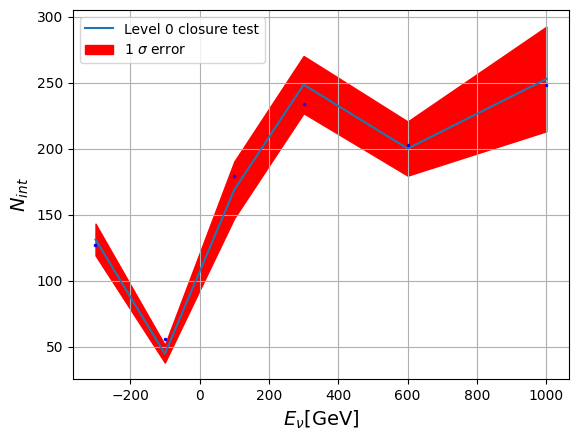

In [ ]:

mean_N_event_fits = np.mean(N_event_pred,axis=0)
sigma_N_event_fits = np.std(N_event_pred,axis=0)

mean_N_event_fit = mean_N_event_fits.flatten()
sigma_N_event_fit = sigma_N_event_fits.flatten()
xvals_per_obs = np.array(xvals_per_obs)
sorted_indices = np.argsort(xvals_per_obs)

# Sort both arrays using the same indices
sorted_xvals_per_obs = xvals_per_obs[sorted_indices]
sorted_mean_N_event_fit = mean_N_event_fit[sorted_indices]
sorted_sigma_N_event_fit = sigma_N_event_fit[sorted_indices]
level0data = level0[0]
sorted_level0 = level0data[sorted_indices]

plt.plot(sorted_xvals_per_obs,sorted_mean_N_event_fit,label="Level 0 closure test")

plt.fill_between(sorted_xvals_per_obs,(sorted_mean_N_event_fit+sorted_sigma_N_event_fit),(sorted_mean_N_event_fit-sorted_sigma_N_event_fit),label=r"1 $\sigma$ error",color = 'red')

# plt.plot(xvals_per_obs[i],events_per_obs[i],'go',markersize=1.5)
plt.plot(sorted_xvals_per_obs,sorted_level0,'bo',markersize=1.5)
# plt.errorbar(xvals_per_obs[i],events_per_obs[i],yerr=np.sqrt(sig_tot),label='POWHEG +PY8 NLO',color = 'green',alpha=0.6 )
# plt.fill_between(xvals_per_obs[i],events_per_obs[i]+np.sqrt(sig_tot), events_per_obs[i]-np.sqrt(sig_tot),color = 'green',alpha=0.6)
plt.xlabel(r"$E_{\nu}$[GeV]",fontsize = 14)
plt.ylabel(r"$N_{int}$",fontsize = 14)
plt.grid()
plt.legend()
# plt.savefig('N_int_fit.pdf')
plt.show()
    

In [ ]:
# Quantitative validation of PDF uncertainties in closure tests
# theoretical prediction for # of events
pdf = "faserv"
lowx = -8
n=50
# x_vals = generate_grid(lowx,n)

faser_pdf,x_faser = read_pdf(pdf,x_vals)
postfit_measures = Measures(cov_matrix, pdf, N_event_pred)
delta_chi = postfit_measures.compute_delta_chi(num_obs, fk_tables, binwidths, level1[0],x_vals)
print(f'delta chi^2 = {delta_chi}')

phi_chi_squared = postfit_measures.compute_phi(data, chi_squares)
print(f'phi level 2 = {phi_chi_squared}')

dist,xnu  = postfit_measures.compute_distance(neutrino_pdfs,x_vals)
plt.plot(xnu,dist,'o')
plt.ylabel('distance to truth')
plt.xlabel('xnu')
plt.show()

TypeError: read_pdf() missing 1 required positional argument: 'particle'

In [ ]:
def compute_accuracy():
    log_spaced = np.logspace(np.log10(1e-5), np.log10(0.1), 10)
    linear_spaced = np.linspace(0.1, 1, 10)
    x_xi_measure = np.concatenate((log_spaced, linear_spaced))
    x_xi_measure= torch.tensor(x_xi_measure, dtype=torch.float32).view(-1,1)

    pdf = "faserv"

    faser_pdf,x_faser = read_pdf(pdf,x_xi_measure)
    faser_pdf =faser_pdf.detach().numpy().squeeze()

    arc_lenghts, chi_squares,pos_penaltys,int_penaltys,N_event_pred, neutrino_pdfs,model = perform_fit(level1,REPLICAS=  1)
    mean_neutrino_pdf =model(x_xi_measure).detach().numpy().squeeze()
    
    return mean_neutrino_pdf,faser_pdf,n

# mean_neutrino_pdf,faser_pdf,n = compute_accuracy()
# xi = np.sum(abs(mean_neutrino_pdf-faser_pdf) < error_neutrino_fit)/ n
# print(f'xi = {xi}')

In [ ]:
def compute_bias_to_variance(num_level1_shifts,level0,level1,level2):
    biases = []
    variances = []
    level1 = np.array(level1)
    level0 = np.array(level0)
    diff_level01 = level1 - level0
    level2 -= diff_level01
    level0 = torch.tensor(level0, dtype=torch.float32)
    for i in range(num_level1_shifts):
        
        # generate level2 data with different level 1 shifts
        r_sys = np.random.normal(0, 1) * sig_sys / 10
        r_stat = np.random.normal(0, 1) * np.sqrt(data) / 10
        level2 += r_sys + r_stat
        level2 = torch.tensor(level2, dtype=torch.float32)
        
        arc_lenghts, chi_squares,pos_penaltys,int_penaltys,N_event_pred, neutrino_pdfs,model = perform_fit(level2,REPLICAS = 3)
        mean_N_events = np.mean(N_event_pred,axis=0)
        mean_N_events = torch.tensor(mean_N_events, dtype=torch.float32)
        
        mean_chi_square = raw_loss_fct(level0[0],mean_N_events,cov_matrix)
        biases.append(mean_chi_square)

        chi_square_level2 = 0
        for j in range (REPLICAS):
            chi_square_level2 += raw_loss_fct(level2[j],mean_N_events, cov_matrix)
        variances.append(chi_square_level2/REPLICAS)


    exp_bias = np.mean(biases)
    exp_variance = np.mean(variances)
    ratio = exp_bias/exp_variance
    return ratio
    
# ratio = compute_bias_to_variance(1,level0,level1,level2)
# print(f'ratio = {ratio}')


#BIAS:
    # mc reps = level 1 + level 2
    # average over level 1: keep level 2 the same, but add different level 1 shifts
    # compute reduced chi square with respect to level 0 data
    # VARIANCE:
    # mc reps = level 1 + level 2
    # average chi^2 over several level 2 shifts
    # do not average over level 1 shifts since it is expected to be constant
    # Compute reduced chi square with respect to all level 2 replics: so do not have to run a lot more fits it seems
    # however since these multiple level 1 fits have to be run anyway, it is no problemo